In [59]:
#v10


In [60]:
from IPython.display import HTML
from vevestaX import vevesta as v
from IPython.display import display, HTML
from PIL import Image
from dask.distributed import Client
from dask.distributed import as_completed
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter
from pandas.io.formats.style import Styler
from pivottablejs import pivot_ui
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import re
from statsmodels.stats.outliers_influence import summary_table
import datetime as dt
import matplotlib
import matplotlib as mp
import matplotlib as mpl
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_market_calendars as mcal
import pickle
import rpy2
import seaborn as sns
import sqlite3
import statsmodels.api as sm
import warnings
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import statsmodels
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
import rpy2
import rpy2.robjects as ro
import time
from clustergram import Clustergram
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.vq import vq
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import scale
from k_means_constrained import KMeansConstrained
from scipy.stats import f
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML as html_print
from IPython.display import display


pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

import pandas as pd
from rpy2.robjects import pandas2ri
from prophet import Prophet

In [61]:
#if not sys.warnoptions:
#    import warnings
#    warnings.simplefilter("ignore")

wd = os.getcwd()

if (os.defpath==".;C:\\bin"):
    os.environ['R_HOME'] = 'C:/Users/User/Documents/R/R-4.1.2'
    os.environ['R_LIBS'] = 'C:/Users/User/Documents/R/R-4.1.2/library'
    from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
else:
    os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'

pandas2ri.activate()


In [62]:

#robjects.ro['version']

base = importr('base')
#grdevices = importr('grDevices')
print(base._libPaths())

timetk = importr('timetk')
magrittr = importr('magrittr')
dplyr = importr('dplyr')
tidyverse = importr('tidyverse')
nbclust = importr('NbClust')
grdevices = importr('grDevices')


[1] "C:/Users/User/Documents/R/R-4.1.2/library"



In [63]:
si = ['03-31','06-30','09-30','12-31']
               
[start,end,prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted, dict_sectors, dict_indexes, dict_sectors_reverse, invert_dict_indexes, list_sector_n_indexes, list_stocks] = pickle.load(open('..\\data\\interim\\data_object.pkl', 'rb'))

fred_friendly_names = ['Consumer Loans','Copper','Iron and Steel','Gold','Unemployment','Market volatility','Commercial-Industrial Loans','Average Weekly Hours','Credit to Income','Consumer Confidence','Oil Prices','Inflation','Housing Prices','Interest Rates','10 Year to 3 Month','Recession Indicator','OECD Leading Indicator','Coincident Index','Index: Industrial Production','Mfr Orders Excl AC','Personal Expenditures',]
fred_names = ['CONSUMER','WPUSI019011','WPU101','GVZCLS','UNRATE','VIXCLS','BUSLOANS','AWHAETP','UMCSENT','TDSP','DCOILWTICO','CPIAUCSL','CSUSHPINSA','FEDFUNDS','T10Y3M','USREC','USALOLITONOSTSAM','USPHCI','INDPRO','NEWORDER','PCE']

dict_fred = dict(zip(*[fred_names,fred_friendly_names]))

nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

fundamentals_quarterlies = pickle.load(open('..\\data\\interim\\fundamental.pkl', 'rb'))
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

sectors.columns = ['Symbol']
indexes.columns = ['Symbol']

newDates = pd.date_range((end+ dt.timedelta(7)).strftime('%Y-%m-%d'), (end + dt.timedelta(92)).strftime('%Y-%m-%d'), freq='W-'+nyse_dates.index[-1].strftime('%a')).map(lambda t: t.strftime('%Y-%m-%d'))


In [64]:
#completed_fred_pvt_df = completed_fred_pvt.asfreq('D').reindex(nyse_dates.index).interpolate(method='time')
completed_fred_pvt_df = completed_fred_pvt

temp_new = completed_fred_pvt.asfreq('D').interpolate(method='time',limit_area='inside').reindex(nyse_dates.index)
temp_dates = pd.date_range(completed_fred_pvt.index[0].strftime('%Y-%m-%d'), completed_fred_pvt.index[-1].strftime('%Y-%m-%d'), freq='D').map(lambda t: t.strftime('%Y-%m-%d'))
nyse_inbetween_temp_dates = nyse_dates.index[(nyse_dates.index >= temp_dates[0]) & (nyse_dates.index <= temp_dates[-1])]
temp_new = temp_new.reindex(nyse_inbetween_temp_dates)

completed_fred_pvt_df = temp_new
completed_fred_pvt_df.columns = [name[1] for name in completed_fred_pvt_df.columns]

np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))]

array(['2017-03-21', '2017-09-29', '2018-04-13', '2018-10-23',
       '2019-05-08', '2019-11-15', '2020-06-01', '2020-12-09',
       '2021-06-23', '2022-01-03', '2022-07-15'], dtype=object)

In [65]:
n_ahead = 13

cv_inner = TimeSeriesSplit(n_splits=10,test_size=n_ahead)
cv_outer = TimeSeriesSplit(n_splits=11,test_size=n_ahead)


In [66]:

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

def print_color(t):
    print(t)
    display(html_print(' '.join([cstr(ti, color=ci) for ti,ci in t])))


In [67]:
def findknee(xdata):
    rate_of_change=(xdata[0]-xdata[-1])/(len(xdata)-1)
    #print(rate_of_change)
    delta = xdata-xdata[-1]
    deltas = []
    deltas.append(delta[0])
    for d in range(1,len(xdata)):
        deltas.append(deltas[d-1]-rate_of_change)
    #print(deltas)
    for d in range(0,len(xdata)):
        deltas[d]=delta[d]-deltas[d]
    return(np.round(np.abs(deltas)))

def deriveANOVA(clf, df):

    labels = clf.labels_
    clusters = clf.n_clusters
    centers = clf.cluster_centers_
        
    within_ss = []

    for n in range(0,clusters):
      #WSS means the sum of distances between the points and the corresponding centroids for each cluster
      data = df[labels==(n)]
      within_ss.append(((data - centers[n])**2).sum(1).sum())

    WSS = total_within_ss = np.sum(within_ss)

    print('wss',total_within_ss)

    #sum of ((deviation from variable means) squared)
    tot_ss = np.sum(np.sum((df-df.mean())**2))
    print('tot_ss',tot_ss)

    cluster_BSS = []
    for n in range(0,clusters):
      #sum((variable/column means cluster - variable/column means data)^2)*len(cluster members)
      BSS = np.sum((df[labels==(n)].mean()-np.array(np.mean(df)))**2)*len(df[labels==(n)])
      cluster_BSS.append(BSS)

    BSS = np.sum(cluster_BSS)
    print('bss',BSS)
    
    return(tot_ss, BSS, within_ss)

def findOptimalK_ANOVA(df, mink=2, maxk=6, init_min=2, init_max=5):

    tss = []
    bss = []
    wss = []

    for k in range(mink,maxk):
        print(k)

        print(max(init_min,k+1))
        size_min_ = max(init_min,k+1)
        size_max_ = max(np.ceil(len(df)/k),init_max)
        if(size_min_>size_max_):
            break
        else:
            clf = KMeansConstrained(n_clusters=k, size_min=size_min_, size_max=size_max_, init='k-means++', n_init=100, max_iter=100, tol=0.0001, verbose=False, random_state=int(time.time()), copy_x=True, n_jobs=4)
            clf.fit_predict(np.array(df))

            tot_ss, BSS, within_ss = deriveANOVA(clf, df)

            wss.append(within_ss)
            tss.append(tot_ss)
            bss.append(BSS)

    return(tss, bss, wss)

In [68]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total


In [69]:
def highlight_cells(val, color_if_true, color_if_false, threshold_):
    color = color_if_true if val >= threshold_ else color_if_false
    return 'background-color: {}'.format(color)

In [70]:
def derive_fb_test_error(npa):
    n_ahead = 13

    subset_train = npa[0]
    subset_test = npa[1]

    base_model = Prophet()

    prophet_df_base = subset_train['Adj Close'].reset_index()#data.reset_index()
    prophet_df_base.columns = ['ds','y']
    prophet_df_base['y'] = np.log(prophet_df_base['y'])

    base_model.fit(prophet_df_base)

    future_base = base_model.make_future_dataframe(periods = n_ahead,freq='W-'+subset_train.index[-1].strftime('%a'))

    forecast_base = base_model.predict(future_base).set_index('ds')[['yhat','yhat_lower','yhat_upper']]
    df_pred_base = np.exp(forecast_base)

    rmse_ = mean_squared_error(subset_test['Adj Close'].tail(n_ahead), df_pred_base['yhat'].tail(n_ahead), squared=True)
    return([[subset_test['Adj Close'].tail(n_ahead)],[df_pred_base['yhat'].tail(n_ahead)],rmse_])

In [71]:
"""
symbol_ = 'BA'

if(str(symbol_)=='None'):
    run=False
else:
    run=True

if(run):
    client = Client('192.168.3.100:8786')
    #client = Client(n_workers=4,threads_per_worker=1)

    s = symbol_
    msize = 2
    date_form = DateFormatter("%Y-%m-%d")

    metrics_df_ = pd.DataFrame(pd.DataFrame(screener_sorted.loc[s]).T[['volume_factor','Adj Close','adf','hurst']])
    subset=prices_df[prices_df['Symbol']==s]
    
    y = subset['Adj Close']
    data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W-'+subset.index[-1].strftime('%a'))
"""

'\nsymbol_ = \'BA\'\n\nif(str(symbol_)==\'None\'):\n    run=False\nelse:\n    run=True\n\nif(run):\n    client = Client(\'192.168.3.100:8786\')\n    #client = Client(n_workers=4,threads_per_worker=1)\n\n    s = symbol_\n    msize = 2\n    date_form = DateFormatter("%Y-%m-%d")\n\n    metrics_df_ = pd.DataFrame(pd.DataFrame(screener_sorted.loc[s]).T[[\'volume_factor\',\'Adj Close\',\'adf\',\'hurst\']])\n    subset=prices_df[prices_df[\'Symbol\']==s]\n    \n    y = subset[\'Adj Close\']\n    data = subset[[\'Adj Close\']].asfreq(\'D\').interpolate().asfreq(\'W-\'+subset.index[-1].strftime(\'%a\'))\n'

In [72]:
def plot_(symbols):    

    #symbols = ['GO']
    decision_metrics_df = pd.DataFrame()

    for symbol_ in symbols:

        print(symbol_)
        if(str(symbol_)=='None'):
            run=False
        else:
            run=True

        if(run):
            client = Client('192.168.3.100:8786')
            #client = Client(n_workers=4,threads_per_worker=1)

            s = symbol_
            msize = 2
            date_form = DateFormatter("%Y-%m-%d")

            metrics_df_ = pd.DataFrame(pd.DataFrame(screener_sorted.loc[s]).T)#[['volume_factor','Adj Close','adf','hurst']])
            subset=prices_df[prices_df['Symbol']==s]

            dates = []
            for t in subset.index.values:
                d = pd.Timestamp(t).strftime('%Y-%m-%d')
                dates.append(d)
                dto = datetime.strptime(d, '%Y-%m-%d').date()

            old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
            new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
            x = new_ordinal    

            lookup_index_ = []

            labels = list()
            print("symbol:",s)

            symbol_sector = screener_sorted.loc[symbol_]['Sector Symbol']

            print("sector:",dict_sectors_reverse[symbol_sector])
            symbol_index = screener_sorted.loc[s]['Index Symbol']

            try:
                matched_index_name = indexes.iloc[np.where(indexes['Symbol'].values==s)].index[0]
            except:
                try:
                    matched_index_name = screener_sorted.loc[s]['Index Symbol']
                except:
                    matched_index_name = "error"

            print("Index:",dict_indexes[matched_index_name])

            print("Volume Factor:",screener_sorted.iloc[np.where(screener_sorted.index==s)]['volume_factor'][0])

            print("sector_risk_trend_factor:",screener_sorted[screener_sorted.index==s]['sector_risk_trend_factor'][0])
            print("risk trend factor:",screener_sorted.iloc[np.where(screener_sorted.index==s)]['risk_trend_factor'][0])

            temp = pd.DataFrame(market_data.loc[s])
            print(temp[np.array(temp!='error')].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().T)

            last_date = pd.DataFrame(subset.iloc[-1][['21dBOLD','21dMA-TP','21dBOLU']],index=[prices_df[prices_df['Symbol']==s].index[-1].strftime('%Y-%m-%d')]).index[0]

            bbands = pd.DataFrame(subset.iloc[-1][['Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']]).T
            bbands['90d_lower'] = bbands['90dSMA']-bbands['90dSDev']*2
            bbands['90d_upper'] = bbands['90dSMA']+bbands['90dSDev']*2

            bbands.index = [last_date]
            display(bbands)

            display(metrics_df_)

            mean_revert_flag = False

            if(metrics_df_['adf'][0]<.05):
                print("ADFuller H0 rejected @ .05, Mean Reverting TS")
                if(bbands['Adj Close'][0]<bbands['90d_lower'][0]):
                    colored_text = colored(255, 0, 0, "Quarter Mean Reverting buy signal")
                    print(colored_text)
                    mean_revert_flag = True
                if(bbands['Adj Close'][0]<bbands['21dBOLU'][0]):
                    colored_text = colored(255, 0, 0, "Month Mean Reverting buy signal")
                    print(colored_text)
                    mean_revert_flag = True    

            l_axis_legend = pd.DataFrame(['symbol', 'trailing_1yr_max', 'trailing_1yr_min', '30d_vol_2yr','risk_trend_factor/linear','supply_trend_1yr'],index=['blue','green','red','orange','black','yellow'],columns=['legend'])

            r_axis_legend = pd.DataFrame(['sector','index'],index=['magenta','cyan'],columns=['legend'])

            display_side_by_side([l_axis_legend, r_axis_legend], ['l axis', 'r axis'])        

            f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=False,figsize=(22,5))
            ax1.plot(subset['30d_vol_2yr'],color='orange')
            #plt.title('30d_vol_2yr')
            ax1.set_xticklabels(subset[['30d_vol_2yr']].dropna().index, rotation = 45)

            locator = matplotlib.dates.AutoDateLocator()
            formatter = matplotlib.dates.ConciseDateFormatter(locator)

            ax1.xaxis.set_major_locator(locator)
            ax1.xaxis.set_major_formatter(formatter)

            ax1.xaxis.set_major_formatter(date_form)

            ax2.plot(subset['risk_trend_factor'],color='black')
            ax2.set_xticklabels(subset[['risk_trend_factor']].dropna().index, rotation = 45)

            locator = matplotlib.dates.AutoDateLocator()
            formatter = matplotlib.dates.ConciseDateFormatter(locator)

            ax2.xaxis.set_major_locator(locator)
            ax2.xaxis.set_major_formatter(formatter)

            ax2.xaxis.set_major_formatter(date_form)

            ax3_ = ax3.twinx()
            ax5_ = ax5.twinx()        
            ax4_ = ax4.twinx()

            y = subset['Adj Close']

            def myfunc(x):
                return slope * x + intercept

            slope, intercept, r, p, std_err = stats.linregress(x, y)

            mymodel = list(map(myfunc, x))

            ax3.plot(x, y,marker = '.',markersize=msize, color = 'b')
            ax3.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
            ax3.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
            ax3_.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')
            ax3.plot(x, mymodel, color = 'k')

            l = matplotlib.dates.AutoDateLocator()
            f = matplotlib.dates.ConciseDateFormatter(l)    

            ax3.set_xticklabels(ax3.get_xticks(), rotation = 45)

            locator = matplotlib.dates.AutoDateLocator()
            formatter = matplotlib.dates.ConciseDateFormatter(locator)

            ax3.xaxis.set_major_locator(locator)
            ax3.xaxis.set_major_formatter(formatter)
            ax3.xaxis.set_major_formatter(date_form)

            if(symbol_sector=='error'):
                pass
            else:
                if(np.sum(sectors['Symbol'].values==s)>0):
                    pass
                else:
                    sector_subset = prices_df[prices_df['Symbol']==symbol_sector]
                    print("Sector Volume Factor:",screener_sorted.iloc[np.where(screener_sorted.index==symbol_sector)]['volume_factor'][0])
                    print("Sector Risk Trend Factor:",screener_sorted.iloc[np.where(screener_sorted.index==symbol_sector)]['risk_trend_factor'][0])
                    #ax3_.plot(x, (sector_subset['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
                    ax4.plot(x, (sector_subset['Adj Close']).iloc[-len(subset):],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))
                    ax4.plot(x, (sector_subset['trailing_1yr_max']).iloc[-len(subset):],marker = '.',markersize=msize, color = 'g')
                    ax4.plot(x, (sector_subset['trailing_1yr_min']).iloc[-len(subset):],marker = '.',markersize=msize, color = 'r')
                    ax4_.plot(x, (sector_subset['supply_trend_1yr']).iloc[-len(subset):],marker = '.',markersize=msize,color='y',linestyle=(0, (3, 10, 1, 10)))
                    ax4.set_xticklabels(subset.dropna().index, rotation = 45)
                    ax4.xaxis.set_major_formatter(date_form)

            if(str(screener_sorted.loc[s]['Index Symbol'])!='nan'):
                if(screener_sorted.loc[s]['Index Symbol']!='error'):
                    index_subset = prices_df[prices_df['Symbol']==screener_sorted.loc[s]['Index Symbol']]
                    print("Index Volume Factor:",screener_sorted.iloc[np.where(screener_sorted.index==screener_sorted.loc[s]['Index Symbol'])]['volume_factor'][0])
                    print("Index Risk Trend Factor:",screener_sorted.iloc[np.where(screener_sorted.index==screener_sorted.loc[s]['Index Symbol'])]['risk_trend_factor'][0])
                    ax5.plot(x, index_subset['Adj Close'].iloc[-len(subset):],marker = '.',markersize=msize,color='c',linestyle=(0, (1, 10)))
                    ax5.plot(x, index_subset['trailing_1yr_max'].iloc[-len(subset):],marker = '.',markersize=msize, color = 'g')
                    ax5.plot(x, index_subset['trailing_1yr_min'].iloc[-len(subset):],marker = '.',markersize=msize, color = 'r')
                    ax5_.plot(x, index_subset['supply_trend_1yr'].iloc[-len(subset):],marker = '.',markersize=msize,color='y',linestyle=(0, (1, 10)))
                    ax5.set_xticklabels(index_subset.dropna().index, rotation = 45)
                    ax5.xaxis.set_major_formatter(date_form)

            plt.show()

            data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W-'+subset.index[-1].strftime('%a'))

            npa_rmse_inner = []

            for trainv_ix, test_ix in cv_inner.split(data.index):

                npa_rmse_inner.append([data.iloc[trainv_ix],data.iloc[test_ix]])

            npa_rmse_outer = []

            for trainv_ix, test_ix in cv_outer.split(data.index):

                npa_rmse_outer.append([data.iloc[trainv_ix],data.iloc[test_ix]])        

            print("fbprophet next 13 weeks")

            #starting from next week

            future = client.map(derive_fb_test_error, npa_rmse_inner)        

            rmses_inner = []

            for f in as_completed(future):
                if(f.status=="error"):
                    rmses_inner.append(np.nan)
                else:
                    rmses_inner.append(f.result())

            rmses_inner_ = [t[2] for t in rmses_inner]
            rmse_ = [r for r in rmses_inner_]

            rmse_inner_flags = [np.nanmean(rmse_),np.nanstd(rmse_)]

            print("inner cv scores:")
            inner_rmse_df = pd.DataFrame([rmse_inner_flags],columns=['mean','std'])

            scores = inner_rmse_df['mean'].values
            sdevs = inner_rmse_df['std'].values
            print("best inner cv score, sdev (11 folds):",scores[np.argmin(scores)],sdevs[np.argmin(scores)])

            future = client.map(derive_fb_test_error, npa_rmse_outer)
            results_rmses_outer = []

            for f in as_completed(future):
                if(f.status=="error"):
                    results_rmses_outer.append([np.nan])
                else:
                    results_rmses_outer.append(f.result()) 

            results_rmses_outer_ = [t[2] for t in results_rmses_outer]
            test_score_mean = np.nanmean([r for r in results_rmses_outer_])
            test_score_std = np.nanstd([r for r in results_rmses_outer_])

            client = Client('192.168.3.100:8786')

            y_s = [t[0] for t in results_rmses_outer]
            y_hats = [t[1] for t in results_rmses_outer]
            test_errors_ = np.array(y_s)-np.array(y_hats)
            np.std(test_errors_,axis=0)
            std_resid = test_errors_/((np.sum(test_errors_)**2)/(len(test_errors_)-2)**.5)

            std_error_test = np.std(test_errors_,axis=0)

            print("test cv mean error, stdev (10 folds):",test_score_mean,test_score_std)

            m = Prophet(interval_width=0.95)

            prophet_df = data['Adj Close'].reset_index()#data.reset_index()
            prophet_df.columns = ['ds','y']
            prophet_df['y'] = np.log(prophet_df['y'])
            m.fit(prophet_df)

            future_ = m.make_future_dataframe(periods = n_ahead,freq='W-'+nyse_dates.index[-1].strftime('%a'))

            forecast = m.predict(future_).set_index('ds')[['yhat','yhat_lower','yhat_upper']]
            df_pred = np.exp(forecast)

            #fb forecast
            temp_df = pd.DataFrame(data['Adj Close']).reset_index()
            temp_df.columns = ['ds','Adj Close']
            temp_df.set_index('ds',inplace=True)

            s_date = df_pred.tail(n_ahead).index[np.argmax(df_pred['yhat'].tail(n_ahead).values)].strftime('%Y-%m-%d')

            print("sell date:",s_date)
            e_return = np.array((np.max(df_pred['yhat'].tail(n_ahead).values)-metrics_df_['Adj Close'])/metrics_df_['Adj Close'])[0]
            p_metrics = pd.DataFrame(df_pred.tail(n_ahead).iloc[np.argmax(df_pred['yhat'].tail(n_ahead).values)]).T
            print("expected return:",e_return)

            days_delta = (datetime.strptime(s_date, '%Y-%m-%d') - datetime.strptime(end.strftime('%Y-%m-%d'), '%Y-%m-%d')).days
            try:
                discounted_return = (1+e_return)**(1/days_delta)-1
            except:
                discounted_return = 0
            qtr_return = (1+discounted_return)**92

            print("discounted return:",discounted_return)
            print("quarter return:",qtr_return)

            #95% 2 tail
            t_score = stats.t.ppf(1-0.025, len(test_errors_))

            prediction_interval_yhat_upper = df_pred[['yhat']].tail(n_ahead)+(std_error_test.reshape(n_ahead,1)*t_score)
            prediction_interval_yhat_lower = df_pred[['yhat']].tail(n_ahead)-(std_error_test.reshape(n_ahead,1)*t_score)

            cv_outter_std_ratio = test_score_std / e_return
            cv_outter_err_ratio = test_score_mean / e_return                        

            stop_loss_price = pd.DataFrame(np.mean(pd.concat([df_pred[['yhat']].tail(n_ahead),prediction_interval_yhat_lower],axis=1),axis=1)).iloc[0].values[0]
            decision_metrics_df_ = pd.DataFrame([s,e_return,discounted_return,qtr_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['yhat_upper'].values[0],p_metrics['yhat_lower'].values[0]])#,columns=)#,index=[s_])#.sort_values(by='disc_rtn',ascending=False,inplace=True)
            decision_metrics_df_ = decision_metrics_df_.T
            decision_metrics_df_.columns=['SYMBOL','exp_return','discounted_return','qtr_return','sell_date','stop_loss_price','days_delta','disc_rtn','qtr_rtn','outer_cv_avg_abs_err_n11','outer_cv_std_n11','mean_revert_flag','yhat_upper','yhat_lower']
            decision_metrics_df_.index = [symbol_]       

            bbands_ = bbands[set(bbands.columns).difference(['Adj Close'])]
            bbands_.index = [symbol_]

            outer_cv_avg_abs_err_n11_ratio = pd.DataFrame(test_score_mean/screener_sorted.loc[symbol_]['Adj Close'],columns=['outer_cv_avg_abs_err_n11_ratio'],index=[symbol_])
            outer_cv_std_n11_ratio = pd.DataFrame(test_score_std/screener_sorted.loc[symbol_]['Adj Close'],columns=['outer_cv_std_n11_ratio'],index=[symbol_])


            decision_metrics_df_ = pd.concat([decision_metrics_df_,bbands_,metrics_df_[metrics_df_.columns.difference(['21dBOLD', '21dMA-TP', '21dBOLU','90dSMA', '90dSDev'])],outer_cv_avg_abs_err_n11_ratio,outer_cv_std_n11_ratio],axis=1)
            #decision_metrics_df_ = decision_metrics_df_.sort_values(by='exp_return',ascending=True)                        

            print("Outer CV Error / Price Ratio",decision_metrics_df_['outer_cv_avg_abs_err_n11_ratio'])
            print(" Outer CV StdDev / Price Ratio",decision_metrics_df_['outer_cv_std_n11_ratio'])

            decision_metrics_df = pd.concat([decision_metrics_df,decision_metrics_df_],axis=0)            

            savePlot=False
            if(decision_metrics_df_['outer_cv_avg_abs_err_n11_ratio'].values[0]<.9):
                if(decision_metrics_df_['outer_cv_std_n11_ratio'].values[0]<.9):
                    if(decision_metrics_df_['qtr_return'].values[0]>1.089):
                        savePlot=True                 

            plt.plot(temp_df)
            plt.plot(df_pred)
            plt.legend(['Adj Close','yhat','yhat_lower','yhat_upper'],loc=2)
            plt.xticks(rotation = 45,size=8)

            if(savePlot):
                plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_'+symbol_+'_full_forecast.png', dpi=300, format='png', bbox_inches='tight')           
            plt.show()

            plt.plot(temp_df.tail(n_ahead))
            plt.plot(df_pred.tail(n_ahead*2))
            plt.plot(prediction_interval_yhat_upper,linestyle = 'dashed')
            plt.plot(prediction_interval_yhat_lower,linestyle = 'dashed')

            plt.legend(['Adj Close','yhat','yhat_lower','yhat_upper','pi_upper','pi_lower'],loc=2)

            plt.xticks(rotation = 45,size=8)

            if(savePlot):
                plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_'+symbol_+'_13w_forecast.png', dpi=300, format='png', bbox_inches='tight')
            plt.show()

            fcst = m.predict(future_)
            fig = m.plot(fcst)

            if(savePlot):
                plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_'+symbol_+'_fb_sim_forecast.png', dpi=300, format='png', bbox_inches='tight')
            plt.show()            

            if(np.sum(np.array(fundamental_entries)==s)>0):
                loc = np.where(np.array(fundamental_entries)==s)[0][0]
                for item in fundamentals_quarterlies[loc][1]:
                    if(type(item[1]) == type(None)):
                        pass
                    else:
                        if(len(item[1])>0):
                            #print(len(item[1]))
                            print(item)
            client.close()


    decision_metrics_df.sort_values(by='exp_return',ascending=False,inplace=True)

    display(decision_metrics_df)

    
    #V.dump(techniqueUsed = end.strftime('%Y-%m-%d')+'_FBProphet', filename = 'fbpropet_metrics.xlsx', message = "FBProphet", version =1)
    decision_metrics_df.to_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_decision_metrics_df.csv')

In [73]:
def colored(r, g, b, text):
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"

In [74]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [75]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

In [76]:
nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)

In [77]:
sector_performance_return = pd.DataFrame()
sector_performance_Q_smoothed_return = pd.DataFrame()

for v in [*indexes['Symbol'],*sectors['Symbol']]:
    subset = prices_df[prices_df['Symbol'] == v]
    #subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_ = subset.asfreq('D').interpolate().asfreq('Q')[['Adj Close']].pct_change()
    #print(subset_)
    #subset_qs = subset.set_index('Date')[['Adj Close']].pct_change().rolling(63).mean()
    subset_qs = subset[['Adj Close']].pct_change().rolling(63).mean()
    subset_.index = subset_.index.values.astype('M8[D]')
    subset_qs.index = subset_qs.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    #tail = subset[subset.set_index('Date').index>=dt_str]
    tail = subset[subset.index>=dt_str]
    #dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    dt_str = subset.index[-1].strftime('%Y-%m-%d')
    #tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    tail_ = pd.DataFrame([(tail['Adj Close'][-1]-tail['Adj Close'][0])/tail['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)
    sector_performance_Q_smoothed_return = pd.concat([sector_performance_Q_smoothed_return,subset_qs],axis=1)

In [78]:
sector_performance_Q_smoothed_return.columns = [*[i for i in indexes.index],*[v for v in sectors.index]]
sector_performance_return.columns = [*[i for i in indexes.index],*[v for v in sectors.index]]

In [79]:
"""
from scipy import stats as st
from scipy.stats import t

std_indexes = pd.DataFrame()
seasonal_indexes = pd.DataFrame()

warnings.filterwarnings('ignore')
for spr in sector_performance_return.columns:
    #print(spr)
    s = sector_performance_return[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in sector_performance_return[spr].index:

        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes = pd.concat([std_indexes,ct_std],axis=1)
    seasonal_indexes = pd.concat([seasonal_indexes,ct],axis=1)

seasonal_indexes.columns = sector_performance_return.columns

std_indexes.columns = sector_performance_return.columns
    
seasonal_indexes = seasonal_indexes.T

std_indexes = std_indexes.T

si = ['03-31','06-30','09-30','12-31']

print("Seasonal Indexes")

seasonal_index_values_sorted = []
seasonal_index_names_sorted = []
#B = seasonal_indexes[si]
for c in seasonal_indexes[si].columns:
    seasonal_index_values_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).values)
    seasonal_index_names_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).index.values)

temp_seasonal_index_values_sorted = pd.DataFrame(seasonal_index_values_sorted).T
temp_seasonal_index_values_sorted.columns = seasonal_indexes[si].columns

temp_seasonal_index_names_sorted = pd.DataFrame(seasonal_index_names_sorted).T
temp_seasonal_index_names_sorted.columns = seasonal_indexes[si].columns

A = temp_seasonal_index_values_sorted
B = temp_seasonal_index_names_sorted 

display(B.style.apply(b_g,cmap=cm))

display(seasonal_indexes[si].style.background_gradient(cmap = cm,axis=0))

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
print("Current")

display(seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))    

#calculate p-value
n=5

print("standard deviations")
display(std_indexes[si])
t_scores = (seasonal_indexes[si])/(std_indexes[si]/np.sqrt(n))
print("t scores")
display(t_scores)
print("p values")
p_values = pd.DataFrame(t.cdf(t_scores, df=n-2),index=seasonal_indexes[si].index,columns=seasonal_indexes[si].columns)

display(p_values.style.applymap(highlight_cells, color_if_true='green', color_if_false='yellow', threshold_=.5))

p_values.hist()
"""

'\nfrom scipy import stats as st\nfrom scipy.stats import t\n\nstd_indexes = pd.DataFrame()\nseasonal_indexes = pd.DataFrame()\n\nwarnings.filterwarnings(\'ignore\')\nfor spr in sector_performance_return.columns:\n    #print(spr)\n    s = sector_performance_return[[spr]]\n    #print(s)\n    years = []\n    quarters = []\n    for d in sector_performance_return[spr].index:\n\n        d_ = d.strftime(\'%Y-%m-%d\')\n        #print(d_)\n\n        datem = dt.datetime.strptime(d_, "%Y-%m-%d")\n        years.append(str(datem.year))\n        #print(datem.year)       # 2021\n        m = datem.month\n        d = datem.day\n        if(len(str(m))==1):\n            m = \'0\'+str(m)\n        else:\n            m = str(m)\n        if(len(str(d))==1):\n            d = \'0\'+str(d)\n        else:\n            d = str(d)\n        quarters.append(m+"-"+d)\n\n    s[\'Years\'] = years\n    s[\'Quarters\'] = quarters\n    ct = pd.crosstab(s[\'Years\'], s[\'Quarters\'],values=s[spr],aggfunc=np.mean).mean(axi

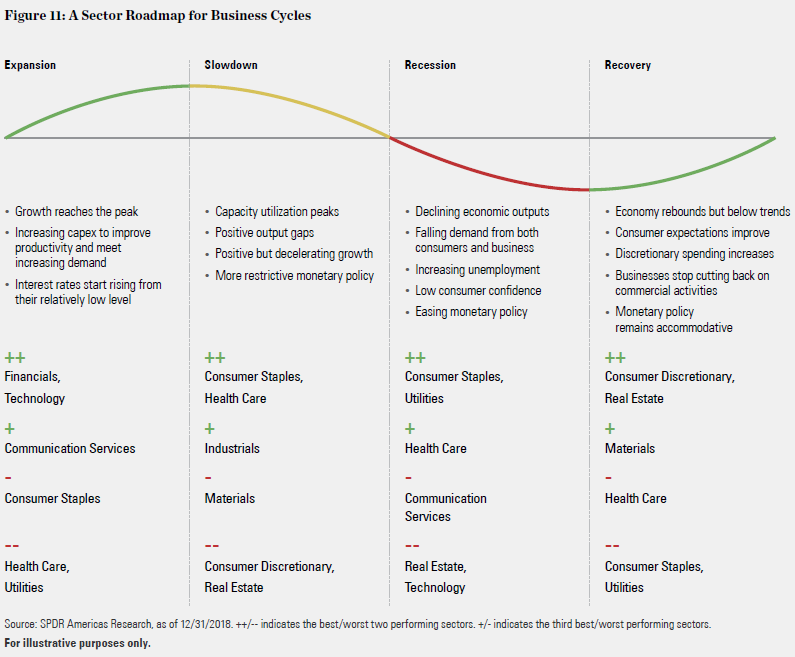

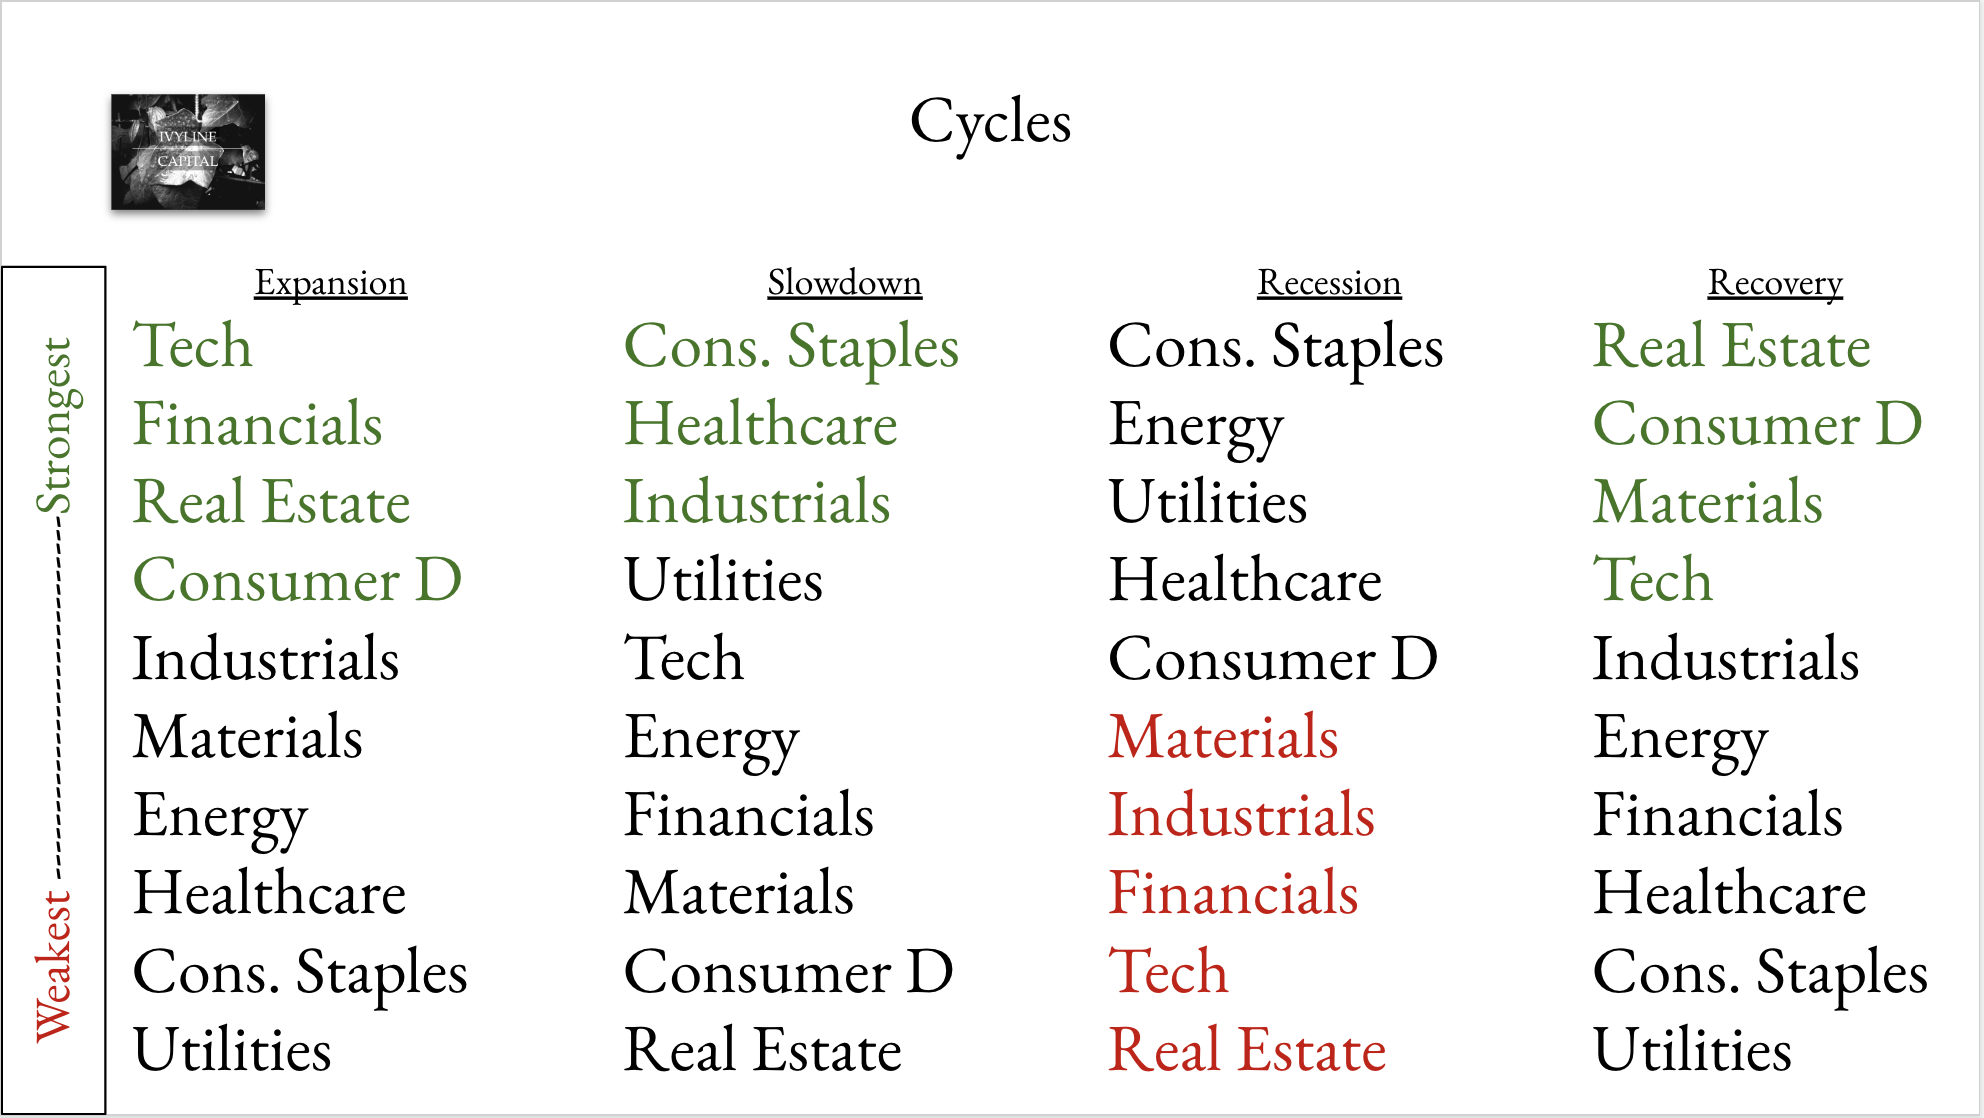

In [80]:
cycles_ = ['Expansion','Slowdown','Recession','Recovery']

path=r"..\data\\interim\\Business cycles.png"
display(Image.open(path))
path=r"..\data\\interim\\Business Cycles-2.png"
display(Image.open(path))

In [81]:
sector_performance_returned_no_dup = sector_performance_return.loc[~sector_performance_return.index.duplicated(keep ='first')]
sector_performance_return_pvt = sector_performance_returned_no_dup[sector_performance_returned_no_dup.iloc[-1].sort_values(ascending=False).index]

sector_performance_return_pvt_heatmap = sector_performance_return_pvt.style.background_gradient(cmap = cm,axis=None)
display(sector_performance_return_pvt_heatmap)

sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_returned_no_dup.T.columns:
    #print(c)
    temp = pd.DataFrame(sector_performance_returned_no_dup.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(sector_performance_returned_no_dup.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    
A = sector_performances_values
B = sector_performance_returned_no_dup.T

df = B.style.apply(b_g,cmap='RdYlGn')

display(df)


,Consumer Discretionary ETF,Information Technology ETF,SP400,Communication Services ETF,SP600,SP1500,SP500,Financials ETF,Industrials ETF,Energy ETF,Real Estate ETF,Materials ETF,Health Care ETF,Consumer Staples ETF,Utilities ETF
2017-03-31 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2017-06-30 00:00:00,0.028386,0.041388,0.031752,-0.024136,0.018327,0.030375,0.030708,0.038955,0.042167,-0.078709,0.017375,0.026999,0.072895,0.010040,0.022113
2017-09-30 00:00:00,0.014521,0.083223,0.035020,0.015498,0.064962,0.044807,0.045666,0.052789,0.052781,0.069612,0.008095,0.066617,0.040565,-0.012346,0.031518
2017-12-31 00:00:00,0.097848,0.093087,0.074139,0.000763,0.038747,0.066880,0.069917,0.073683,0.066175,0.073946,0.012742,0.071798,0.018576,0.059268,0.000687
2018-03-31 00:00:00,-0.001942,0.020711,-0.003978,-0.085669,-0.011631,-0.021321,-0.024130,-0.015065,-0.033542,-0.078807,-0.086159,-0.072483,-0.020049,-0.073521,-0.033734
2018-06-30 00:00:00,0.088528,0.080437,0.045520,0.035862,0.106722,0.052094,0.047568,-0.011331,-0.008057,0.150528,0.094633,0.036210,0.055259,0.006353,0.053422
2018-09-30 00:00:00,0.066008,0.117719,0.032902,0.023115,0.032842,0.070536,0.078236,0.031675,0.094874,0.021911,0.000044,0.007338,0.137698,0.050064,0.019751
2018-12-31 00:00:00,-0.162070,-0.174415,-0.172165,-0.143117,-0.193040,-0.142834,-0.137319,-0.138848,-0.183620,-0.267451,-0.058855,-0.154310,-0.108129,-0.055862,0.009925
2019-03-31 00:00:00,0.157197,0.217473,0.157497,0.139541,0.124660,0.151853,0.144236,0.109942,0.183161,0.178564,0.173365,0.126958,0.081835,0.111156,0.103055
2019-06-30 00:00:00,0.040127,0.054745,0.030815,0.035928,0.010843,0.039106,0.040369,0.067026,0.034436,-0.048754,0.015389,0.040951,0.017469,0.036556,0.035855


,2017-03-31 00:00:00,2017-06-30 00:00:00,2017-09-30 00:00:00,2017-12-31 00:00:00,2018-03-31 00:00:00,2018-06-30 00:00:00,2018-09-30 00:00:00,2018-12-31 00:00:00,2019-03-31 00:00:00,2019-06-30 00:00:00,2019-09-30 00:00:00,2019-12-31 00:00:00,2020-03-31 00:00:00,2020-06-30 00:00:00,2020-09-30 00:00:00,2020-12-31 00:00:00,2021-03-31 00:00:00,2021-06-30 00:00:00,2021-09-30 00:00:00,2021-12-31 00:00:00,2022-03-31 00:00:00,2022-06-30 00:00:00,2022-07-20 00:00:00
SP1500,nan,0.030375,0.044807,0.066880,-0.021321,0.052094,0.070536,-0.142834,0.151853,0.039106,0.006291,0.090490,-0.205302,0.206715,0.086119,0.132216,0.070761,0.080495,0.000378,0.103038,-0.049102,-0.163728,0.046687
SP500,nan,0.030708,0.045666,0.069917,-0.024130,0.047568,0.078236,-0.137319,0.144236,0.040369,0.011423,0.089876,-0.194477,0.201618,0.090383,0.121185,0.063518,0.083593,0.002523,0.106772,-0.049099,-0.164711,0.046441
SP600,nan,0.018327,0.064962,0.038747,-0.011631,0.106722,0.032842,-0.193040,0.124660,0.010843,-0.004200,0.082573,-0.328050,0.223617,0.032878,0.312278,0.184526,0.043034,-0.030694,0.049293,-0.058344,-0.144536,0.058691
SP400,nan,0.031752,0.035020,0.074139,-0.003978,0.045520,0.032902,-0.172165,0.157497,0.030815,-0.009122,0.066590,-0.247693,0.259149,0.068091,0.211458,0.084662,0.033635,-0.024123,0.077726,-0.089783,-0.178547,0.071686
Communication Services ETF,nan,-0.024136,0.015498,0.000763,-0.085669,0.035862,0.023115,-0.143117,0.139541,0.035928,-0.002023,0.086727,-0.187109,0.224230,0.097573,0.182130,0.083288,0.108092,-0.021207,-0.037011,-0.114414,-0.216743,0.065086
Consumer Discretionary ETF,nan,0.028386,0.014521,0.097848,-0.001942,0.088528,0.066008,-0.162070,0.157197,0.040127,0.002509,0.056223,-0.231167,0.379795,0.192380,0.172875,0.073815,0.064435,-0.012866,0.099010,-0.103975,-0.254816,0.111184
Consumer Staples ETF,nan,0.010040,-0.012346,0.059268,-0.073521,0.006353,0.050064,-0.055862,0.111156,0.036556,0.056319,0.036517,-0.141472,0.094561,0.098022,0.074374,0.030385,0.029888,-0.018026,0.115277,-0.019862,-0.053953,0.008471
Energy ETF,nan,-0.078709,0.069612,0.073946,-0.078807,0.150528,0.021911,-0.267451,0.178564,-0.048754,-0.075658,0.054552,-0.523877,0.332245,-0.188315,0.300830,0.324479,0.126094,-0.026222,0.050203,0.379204,-0.070721,0.026742
Financials ETF,nan,0.038955,0.052789,0.073683,-0.015065,-0.011331,0.031675,-0.138848,0.109942,0.067026,0.013235,0.096390,-0.330709,0.135641,0.028859,0.253698,0.165207,0.074954,0.024323,0.042310,-0.032929,-0.173466,0.042881
Health Care ETF,nan,0.072895,0.040565,0.018576,-0.020049,0.055259,0.137698,-0.108129,0.081835,0.017469,-0.035439,0.147851,-0.131539,0.164463,0.062281,0.101111,0.025327,0.083442,0.000121,0.077925,-0.045192,-0.074220,0.010870


In [82]:
"""
#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

#seasonal_indexes[si]
seasonally_adjusted = pd.DataFrame()

for s in sector_performance_return.columns:
    
    s_ = pd.DataFrame(sector_performance_return[s])
    #print(sector_performance_return[s])
    years = []
    quarters = []
    
    for d in s_.index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)
        
    s_['Quarter'] = quarters
    si_ = seasonal_indexes.loc[s]
    
    modified = pd.DataFrame()
    #print(si_.index)
    for s_i_ in si_.index:
        #print(s_i_)
        #when it finds the last date (which hopefully isn't a quarter date)
        if(np.sum(np.array(si)==s_i_)==0):
            #print("don't modify")
            #print(s_i_)
            match = []
            for entry in si:
                if(int(s_i_.rsplit("-")[0])<=int(entry.rsplit("-")[0])):
                    match = entry
                    break            

            delta_months = int(match.rsplit("-")[0])-int(s_i_.rsplit("-")[0])
            delta_days_ = int(match.rsplit("-")[1])-int(s_i_.rsplit("-")[1])
            
            delta_days = int(delta_months*(91.25/3)+delta_days_)
            #daily interest
            
            #print(delta_days)
            #print(seasonal_indexes.loc[s].loc[match])
            seasonal_index_to_daily = (1+seasonal_indexes.loc[s].loc[match])**(1/91.25)-1
            #print("Seasonal Index to Daily Discounted Interest Rate:",seasonal_index_to_daily)
            daily_extrapolated = (1+seasonal_index_to_daily)**delta_days-1
            #print(daily_extrapolated)
            #print("Daily ^ delta_days:",daily_extrapolated)
            
            #print(match)
            #print(s_i_)
            seasonally_adjusted_column = pd.DataFrame([seasonal_indexes.loc[s].loc[match] - daily_extrapolated],columns=[s],index=[s_.index[-1]])
            
            
        else:
            seasonally_adjusted_column = pd.DataFrame(s_[s][s_['Quarter']==s_i_] - seasonal_indexes.loc[s].loc[s_i_],columns=[s])
        modified = pd.concat([modified,seasonally_adjusted_column],axis=0)
        modified.sort_index(inplace=True)
    #print(modified)
    seasonally_adjusted = pd.concat([seasonally_adjusted,modified],axis=1)

print("Comparative to Seasonal Indexes, tells you who is over or underperforming.")
print("This is Seasonal Index - Extrapolated Current Quarter.")
print("+: seasonal > current")
print("-: current > seasonal")

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
    
    
std_indexes_seas_adj = pd.DataFrame()
seasonal_indexes_seas_adj = pd.DataFrame()

temp_ = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1])
temp_.columns = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1]).columns.strftime('%Y-%m-%d')
display(temp_.sort_values(by=temp_.columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))

for spr in seasonally_adjusted.columns:
    #print(spr)
    s = seasonally_adjusted[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in seasonally_adjusted[spr].index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    #print(ct)
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes_seas_adj = pd.concat([std_indexes_seas_adj,ct_std],axis=1)
    seasonal_indexes_seas_adj = pd.concat([seasonal_indexes_seas_adj,ct],axis=1)

seasonal_indexes_seas_adj.columns = seasonally_adjusted.columns

std_indexes_seas_adj.columns = seasonally_adjusted.columns
    
seasonal_indexes_seas_adj = seasonal_indexes_seas_adj.T

std_indexes_seas_adj = std_indexes_seas_adj.T

sector_performances_sea_adj = pd.DataFrame()
sector_performances_values_sea_adj = pd.DataFrame()
for c in seasonally_adjusted.T.columns:
    temp = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False).index,columns=[c])
    temp2 = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False),columns=[c])
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances_sea_adj = pd.concat([sector_performances_sea_adj,temp],axis=1)
    sector_performances_values_sea_adj = pd.concat([sector_performances_values_sea_adj,temp2],axis=1)

A = sector_performances_values_sea_adj
B = sector_performances_sea_adj

df_sea_adj = B.style.apply(b_g,cmap='RdYlGn')
display(df_sea_adj)
"""

'\n#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)\n#pd.crosstab(shares_viz[\'Year\'], shares_viz[\'Month\'])\n\n#seasonal_indexes[si]\nseasonally_adjusted = pd.DataFrame()\n\nfor s in sector_performance_return.columns:\n    \n    s_ = pd.DataFrame(sector_performance_return[s])\n    #print(sector_performance_return[s])\n    years = []\n    quarters = []\n    \n    for d in s_.index:\n        d_ = d.strftime(\'%Y-%m-%d\')\n        #print(d_)\n\n        datem = dt.datetime.strptime(d_, "%Y-%m-%d")\n        years.append(str(datem.year))\n        #print(datem.year)       # 2021\n        m = datem.month\n        d = datem.day\n        if(len(str(m))==1):\n            m = \'0\'+str(m)\n        else:\n            m = str(m)\n        if(len(str(d))==1):\n            d = \'0\'+str(d)\n        else:\n            d = str(d)\n        quarters.append(m+"-"+d)\n        \n    s_[\'Quarter\'] = quarters\n    si_ = seasonal_indexes.loc[s]\n    \n    modified = pd.DataFrame()\n    #print

In [83]:
"""
index_performance = []
for v in indexes['Symbol'].values:
    index_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_i = pd.DataFrame(index_performance,index=indexes.index)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted
"""

"\nindex_performance = []\nfor v in indexes['Symbol'].values:\n    index_performance.append([v,screener.loc[v]['risk_trend_factor']])\ntemp_i = pd.DataFrame(index_performance,index=indexes.index)\ntemp_i.columns = ['Symbol','risk_trend_factor']\nindex_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()\nindex_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']\nindex_risk_sorted\n"

In [84]:
"""
sector_performance = []
for v in sectors['Symbol'].values:
    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])
temp_v = sectors.reset_index()
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted
"""

"\nsector_performance = []\nfor v in sectors['Symbol'].values:\n    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])\ntemp_v = sectors.reset_index()\ntemp_v.columns = ['Sector','Symbol']\nsectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    \nsectors_risk_sorted\n"

Rolling Quarterly Mean Return


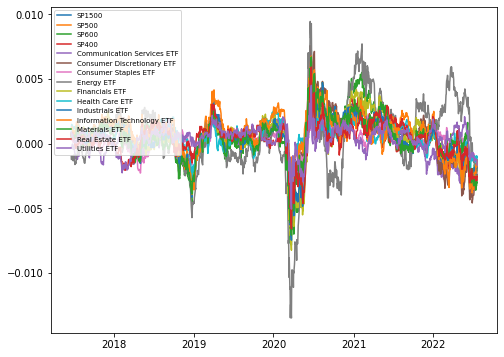

In [85]:
print("Rolling Quarterly Mean Return")
plt.plot(sector_performance_Q_smoothed_return)
plt.legend([*[i for i in indexes.index],*[v for v in sectors.index]],loc=2,fontsize=7)
plt.show()

Quarterly Returns


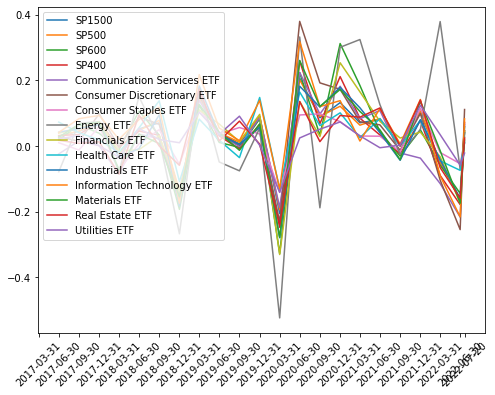

In [86]:
print ("Quarterly Returns")
for v in sector_performance_return.T.index:
    subset = pd.DataFrame(sector_performance_return.T.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.T.index,loc=2)    
plt.show()


In [87]:
"""
plt.plot(seasonal_indexes[si].T)
plt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)
plt.show()
"""

'\nplt.plot(seasonal_indexes[si].T)\nplt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)\nplt.show()\n'

In [88]:
threshold = 1

In [89]:
#risk_trend_threshold

In [90]:
#market_data['sector'] = stock_fundamentals['sector']

In [91]:
#screener[['risk_trend_factor']].replace(['missing','error'], np.NaN).dropna().hist()

In [92]:
#len(screener)

In [93]:
#prices_df.columns

In [94]:
#threshold

In [95]:
#threshold_value = summary.dropna()['risk_trend_factor'].quantile([threshold])

In [96]:
fred_pvt_sample = completed_fred_pvt_df[fred_names].asfreq('D').interpolate(method='time').asfreq('Q').dropna()

In [97]:
temp_filter = screener_sorted['20td_tvf_vel'].replace(['missing','error'], np.nan).dropna()

In [98]:
filtered_screener_sorted = screener_sorted.loc[temp_filter[temp_filter>0].index]

In [99]:
filtered_screener_sorted

,Date,MIN_Lookback_One_Year,MIN_Lookback_2_Months,MIN_Lookback_1_Months,risk_trend_factor,risk_per_share,volume_factor,Adj Close,21dBOLD,21dMA-TP,21dBOLU,90dSMA,90dSDev,adf,hurst,sector_risk_trend_factor,Sector,Sector Symbol,Market Index,Index Symbol
ACC,2022-07-20 00:00:00,51.09,65.019997,65.220001,10.340567,1.380001,1.351069,65.199997,64.157462,64.743651,65.329841,64.704286,0.259415,0.97967,0.432368,error,error,error,SP400,MDYG
MTOR,2022-07-20 00:00:00,32.93,36.279999,36.299999,6.160701,0.560001,1.447887,36.32,36.084308,36.263968,36.443629,36.104286,0.148658,0.341783,0.438615,error,error,error,SP600,SLY
PSB,2022-07-20 00:00:00,165.850006,189.830002,189.830002,5.961009,2.819992,3.62362,187.440002,186.348667,187.058254,187.767842,186.390001,3.208269,0.837126,0.48243,error,error,error,SP400,MDYG
Y,2022-07-20 00:00:00,737.890015,862.869995,862.869995,4.482132,9.22998,1.353436,835.0,830.988677,833.426346,835.864016,833.642578,2.22334,0.474177,0.46603,-4.5,Financial Services,VFH,SP400,MDYG
LNTH,2022-07-20 00:00:00,28.736,69.738998,73.779999,3.157813,15.904999,1.801585,74.160004,59.013094,65.330318,71.647542,64.575913,4.178587,0.998302,0.537072,-2.71317,Healthcare,VHT,SP600,SLY
ROG,2022-07-20 00:00:00,206.130005,274.51001,274.51001,2.939623,16.730011,0.954569,268.109985,257.320001,261.576824,265.833648,263.810992,5.568856,0.7493,0.479475,-5.11111,Technology,VGT,SP600,SLY
MANT,2022-07-20 00:00:00,92.0,94.739998,95.980003,2.698319,1.790001,1.372749,95.849998,95.09041,95.502063,95.913715,91.447041,5.971931,0.554709,0.368821,error,error,error,SP600,SLY
HRB,2022-07-20 00:00:00,26.23,34.959999,36.830002,2.640981,5.709999,0.647661,37.700001,33.537748,36.039048,38.540348,32.907226,4.059889,0.960063,0.460503,-6.808274,Consumer Cyclical,VCR,SP400,MDYG
MCK,2022-07-20 00:00:00,204.660004,339.940002,339.940002,2.373195,40.139984,1.009027,326.600006,310.863324,323.448571,336.033818,321.04336,8.640399,0.998741,0.461176,-2.71317,Healthcare,VHT,SP500,SPY
FCN,2022-07-20 00:00:00,147.380005,170.649994,172.690002,2.358639,30.559998,0.918776,187.600006,167.967093,181.489206,195.01132,170.170595,9.774114,0.975901,0.401004,-4.433986,Industrials,VIS,SP400,MDYG


In [100]:

with localconverter(ro.default_converter + pandas2ri.converter):
      r_from_pd_df = ro.conversion.py2rpy(fred_pvt_sample.melt(ignore_index=False).reset_index().rename(columns={'index': 'Date'}))


In [101]:
#ro.X11()
#ro.windows()
ro.r('''

my_mean <- function(x, na.rm=TRUE) {
  mean(x, na.rm = na.rm)
}

f <- function(y) {
#print(y)

#library(arfima)
#varvefd = arfima(y)
#d = summary(varvefd)$coef[[1]][1]
#return(d)

tsfeature_tbl <- y %>%
group_by(variable) %>%
tk_tsfeatures(
  .date_var = Date,
  .value    = value,
  .period   = 4,
  .features = c("frequency", "stl_features", "entropy", "acf_features", "my_mean"),
  .scale    = TRUE,
  .prefix   = "ts_"
) %>%
ungroup()
    
print(tsfeature_tbl)

set.seed(123)

cluster_tbl <- tibble(
    cluster = tsfeature_tbl %>% 
        select(-variable) %>%
        as.matrix() %>%
        kmeans(centers = 7, nstart = 100) %>%
        pluck("cluster")
) %>%
    bind_cols(
        tsfeature_tbl
    )

cluster_tbl

cluster_tbl %>%
    select(cluster, variable) %>%
    right_join(y, by = "variable") %>%
    group_by(variable) %>%
    plot_time_series(
      Date, value, 
      .color_var   = cluster, 
      .facet_ncol  = 2, 
      .interactive = FALSE
    )
plot(cluster_tbl)

return(tsfeature_tbl)
}
''')
grdevices.png(file="..\\reports\\figures\\temp.png", width=4096, height=1024)
r_f = ro.globalenv['f']
d=(r_f(r_from_pd_df))
#rprint(pp)

time.sleep(3)
#grdevices.dev_copy(device = r.png, filename = "plot.png", width = 1000, height = 500)
grdevices.dev_off()

#From here optional, if you want a waiting time
#Elsewise close the plot manually afterwards with grdevices.dev_off()

#grdevices.dev_off()
#grdevices.dev_off()


# A tibble: 21 x 22
   variable    ts_frequency ts_nperiods ts_seasonal_period ts_trend    ts_spike
   <chr>              <dbl>       <dbl>              <dbl>    <dbl>       <dbl>
 1 CONSUMER               4           1                  4    0.991 0.000000770
 2 WPUSI019011            4           1                  4    0.971 0.00000614 
 3 WPU101                 4           1                  4    0.986 0.00000100 
 4 GVZCLS                 4           1                  4    0.710 0.000757   
 5 UNRATE                 4           1                  4    0.710 0.00107    
 6 VIXCLS                 4           1                  4    0.536 0.00158    
 7 BUSLOANS               4           1                  4    0.919 0.0000474  
 8 AWHAETP                4           1                  4    0.918 0.0000646  
 9 UMCSENT                4           1                  4    0.894 0.0000849  
10 TDSP                   4           1                  4    0.757 0.000503   
# ... with 11 more r

array([1], dtype=int32)

In [102]:
pca = PCA(n_components=0.99, svd_solver='full')

X = np.array(d.iloc[:,1:])

pca.fit(scale(X))
#pca.explained_variance_
pca.explained_variance_ratio_.cumsum()
X_pca = pd.DataFrame(pca.transform(d.iloc[0:,1:]))
X_pca.index = d.index
X_pca.sort_values(by=[0],ascending=False,inplace=True)

TSS_ = []
BSS_ = []
WSS_ = []
silhouettes_ = []

for k in range(2,int(len(d)/2)):
    model = KMeans(n_clusters=k, random_state=0, n_init=100).fit(X)
    #print(model.inertia_)

    codebook = np.array(model.cluster_centers_)
    partition, euc_distance_to_centroids = vq(X, codebook)
    WSS = np.sum(euc_distance_to_centroids**2)
    
    silhouette_avg = silhouette_score(X, model.labels_)

    silhouettes_.append(silhouette_avg)
    
    TSS = np.sum((X-X.mean(0))**2)

    BSS = TSS - WSS

    TSS_.append(TSS)
    BSS_.append(BSS)
    WSS_.append(WSS)
    
    #print(TSS, WSS, BSS)


In [103]:

init_min = 2
init_max = 5


mink = 2
maxk = 6

tss, bss, wss = findOptimalK_ANOVA(X_pca, mink = mink, maxk = maxk)

2
3
wss 132.481509398946
tot_ss 197.8430095399954
bss 65.36150014104938
3
4
wss 102.75923202472659
tot_ss 197.8430095399954
bss 95.08377751526875
4
5
wss 64.60011926444764
tot_ss 197.8430095399954
bss 133.24289027554772
5
6


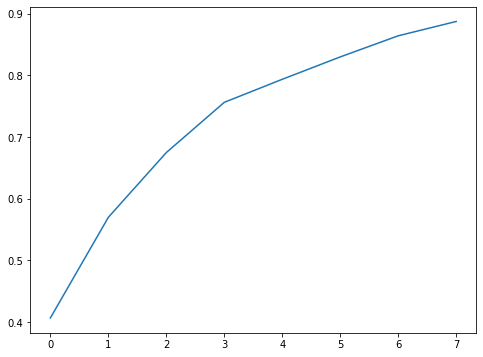

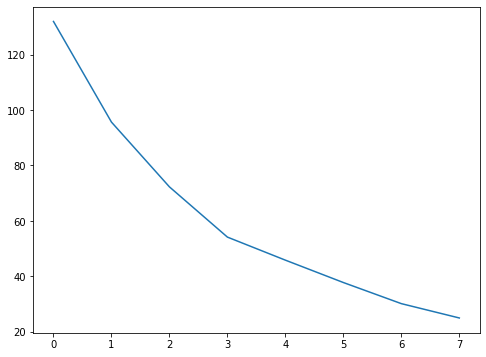

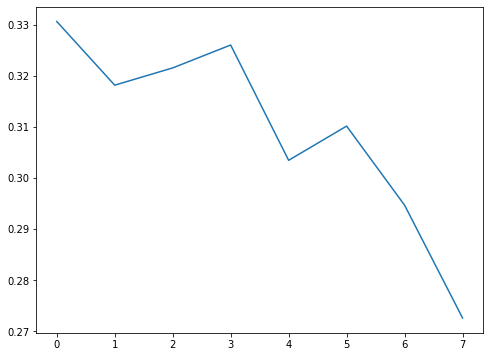

In [104]:
plt.plot(np.array(BSS_)/np.array(TSS_))
plt.show()
plt.plot(np.array(WSS_))
plt.show()
plt.plot(np.array(silhouettes_))
plt.show()



3


C:\Users\User\AppData\Local\Temp\ipykernel_9780\1748299227.py:7: RuntimeWarning: invalid value encountered in true_divide
  temp_df = pd.DataFrame(bss_/wss_).replace([np.inf, -np.inf, np.NaN], 0)


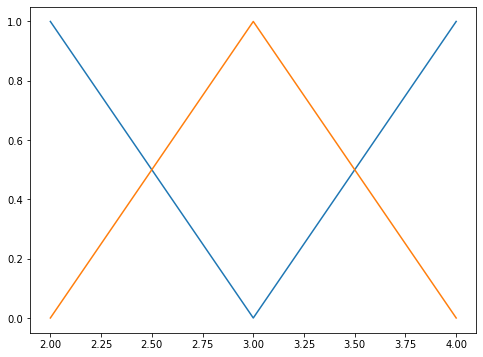

In [105]:

bss_ = findknee(bss)
bss_ = bss_/np.max(bss_)

wss_ = findknee(np.array(pd.DataFrame(wss).mean(1)))
wss_ = wss_/np.max(wss_)

temp_df = pd.DataFrame(bss_/wss_).replace([np.inf, -np.inf, np.NaN], 0)
temp_df.index = np.array(range(0,len(wss_)))+mink
#plt.plot(temp_df)

set_ = np.abs(temp_df-1)
plt.plot(set_)

optimal_k = np.argmin(set_)+mink
plt.plot(abs(set_-1))
 
print(optimal_k)


In [106]:
clf = KMeansConstrained(n_clusters=optimal_k, size_min=init_min, size_max=max(np.ceil(len(X_pca)/optimal_k),init_max), init='k-means++', n_init=100, max_iter=100, tol=0.0001, verbose=False, random_state=None, copy_x=True, n_jobs=4)
clf.fit_predict(X_pca)

labels = clf.labels_
clusters = clf.n_clusters
centers = clf.cluster_centers_

print(labels)

tot_ss, BSS, within_ss = deriveANOVA(clf, X_pca)

Global_F = (BSS/(optimal_k-1))/(np.mean(within_ss)/(len(X_pca)-optimal_k))
global_sig = 1-f.cdf(Global_F, (len(X_pca)-optimal_k), len(X_pca)-1)

ind_F_scores = []

for w in range(0,len(within_ss)):

    dfn = (optimal_k-1)
    dfd = np.sum(labels==w)-optimal_k

    F_score = (BSS/dfn)/(within_ss[w]/(dfd))
    ind_F_scores.append(F_score)

print("Global F:",Global_F)
print("Global Sig:",global_sig)
print("F-Scores:", ind_F_scores)

print("P-Scores:", 1-f.cdf(ind_F_scores, dfn, dfd))

X_pca['cluster'] = labels

[2 2 1 2 1 2 1 1 1 1 2 2 0 2 1 0 0 0 0 0 0]
wss 102.75923202472659
tot_ss 197.8430095399954
bss 95.08377751526875
Global F: 24.983273447338586
Global Sig: 6.254103901426333e-10
F-Scores: [7.128404922900171, 3.5930530894154304, 8.21268512714546]
P-Scores: [0.0480032  0.12786807 0.0383513 ]


K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.02500605583190918 seconds.
K=3 fitted in 0.02200174331665039 seconds.
K=4 fitted in 0.02399611473083496 seconds.
K=5 fitted in 0.029999256134033203 seconds.
K=6 fitted in 0.02999424934387207 seconds.
K=7 fitted in 0.03400158882141113 seconds.


Clustergram(k_range=range(1, 8), backend='sklearn', method='kmeans', kwargs={})

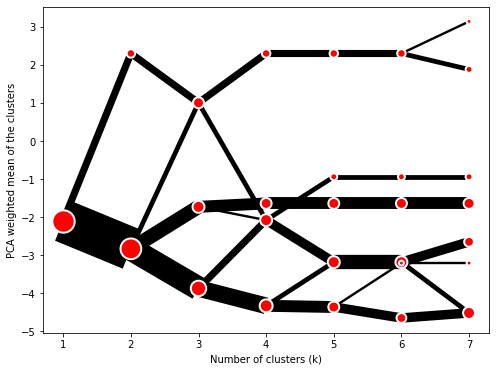

In [107]:


cgram = Clustergram(range(1, 8))
cgram.fit(X_pca)
cgram.plot()
cgram

In [108]:

lengths = []
for i in range(0,max(X_pca['cluster'])+1):
    subset = d.loc[X_pca[X_pca['cluster']==i].index]
    lengths.append(len(subset))
    
colors = ['purple','cyan','magenta','green','red','black','pink','yellow','blue','brown','orange','grey']
my_cmap = LinearSegmentedColormap.from_list(
    'color_map', colors, N=max(lengths))

rescale = lambda y: (y - 0) / (np.max(lengths) - 0)    


Group:  0


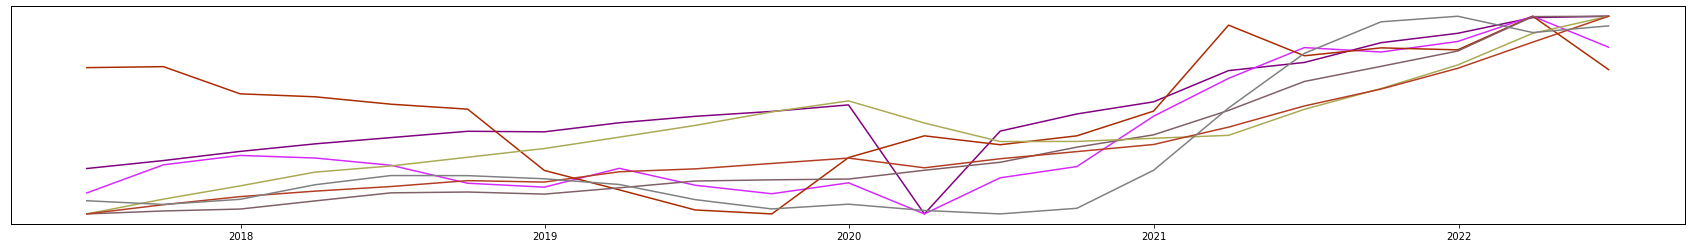

Group:  1


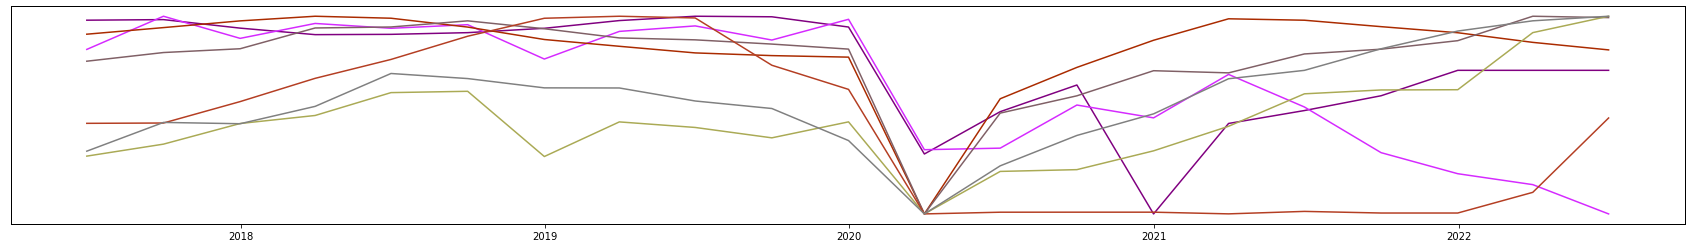

Group:  2


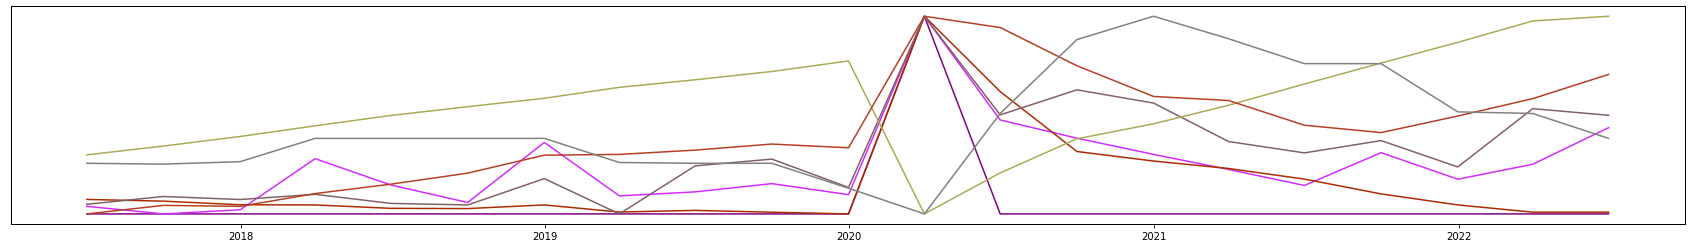

In [109]:

for i in range(0,max(X_pca['cluster'])+1):
    print("Group: ",i)
    subset = d.loc[X_pca[X_pca['cluster']==i].index]
    #
    for c_ in range(0,len(subset['variable'])):
        c = subset['variable'].values[c_]
        try:
            #print(dict_fred[c])
            display(html_print(' '.join([cstr(ti, color=ci) for ti,ci in ((dict_fred[c], colors[c_]),)])))

            #display(html_print(' '.join([cstr(ti, color=my_cmap(rescale(c_))) for ti in (('hello my name is'),)])))
            #print(colored("hello red world", my_cmap(rescale(c_))))
            if(c_==0):
                fig, ax1 = plt.subplots( figsize=(30,4))
                ax1.plot(fred_pvt_sample[c],color=my_cmap(rescale(c_)))
                ax1.get_yaxis().set_ticks([])
            else: 
                ax2 = ax1.twinx()
                ax2.plot(fred_pvt_sample[c],color=my_cmap(rescale(c_)))
                ax2.get_yaxis().set_ticks([])
        #ax1.legend(subset['variable'].values,loc=2)
        except:
            pass
    plt.show()

In [110]:
filter_ = fred_pvt_sample.columns.tolist()
def f3(Y):
    
    #Y = x
    #output_slider_variable.value
    internalFilter = filter_.copy()
    internalFilter.remove(Y)
    all_data_ = pd.concat([fred_pvt_sample[Y],fred_pvt_sample[internalFilter]], axis=1)    
    #print(all_data_.describe())
    display(fred_pvt_sample.describe())
    #x_ticks = all_data_.index[np.arange(0, len(all_data.index), int(len(internalFilter)/5))]
    x_ticks  = []
    for index, element in enumerate(fred_pvt_sample.index):
        if index % int(np.round(len(fred_pvt_sample.index)/10)) == 0:
            x_ticks.append(element)
    plt.plot(fred_pvt_sample[Y])
    plt.xticks(x_ticks, rotation = 45)
    plt.show()        
    plt.hist(fred_pvt_sample[Y], bins='auto')
    plt.show()
    diff = pd.DataFrame((fred_pvt_sample[Y].pct_change())).dropna()
    plt.hist(diff, bins='auto')
    plt.show()
    return(fred_pvt_sample)
    
out = interactive(f3, Y=filter_)

#output_slider_variable.observe(f4, 'value')

print("choose Y")
display(out)


choose Y


interactive(children=(Dropdown(description='Y', options=('CONSUMER', 'WPUSI019011', 'WPU101', 'GVZCLS', 'UNRAT…

nominal, pct_change, pct_change().cumsum
Consumer Loans CONSUMER


C:\Users\User\AppData\Local\Temp\ipykernel_9780\1907383185.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_9780\1907383185.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_9780\1907383185.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index

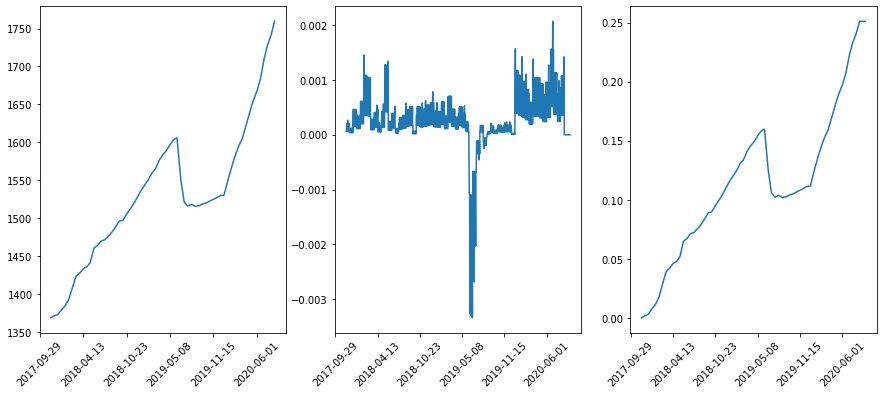

Copper WPUSI019011


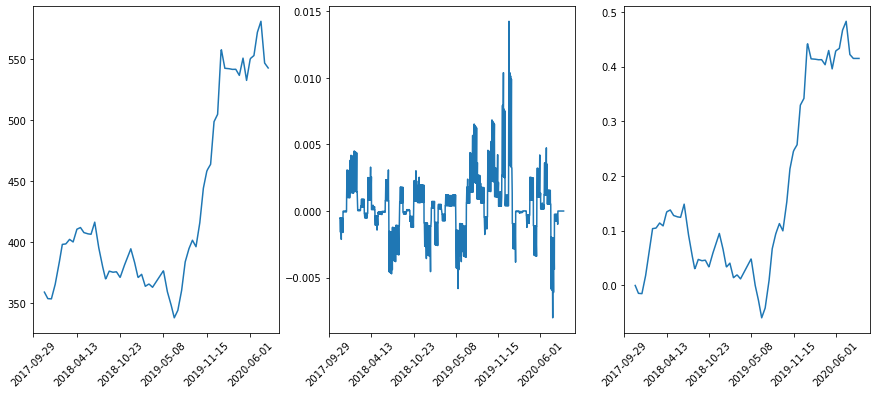

Iron and Steel WPU101


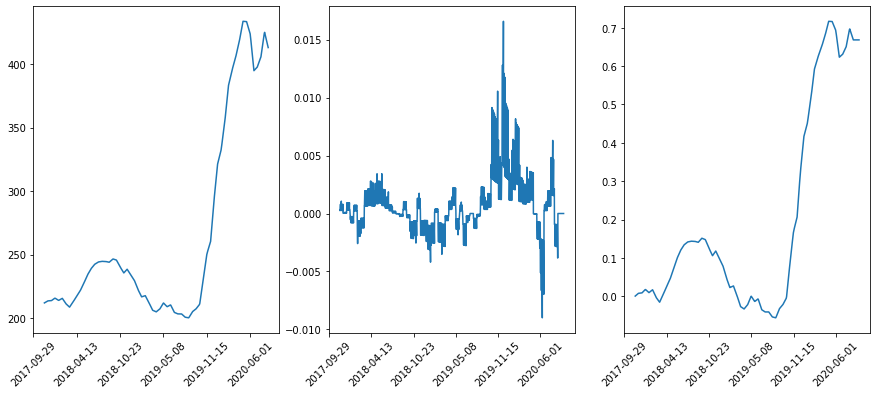

Gold GVZCLS


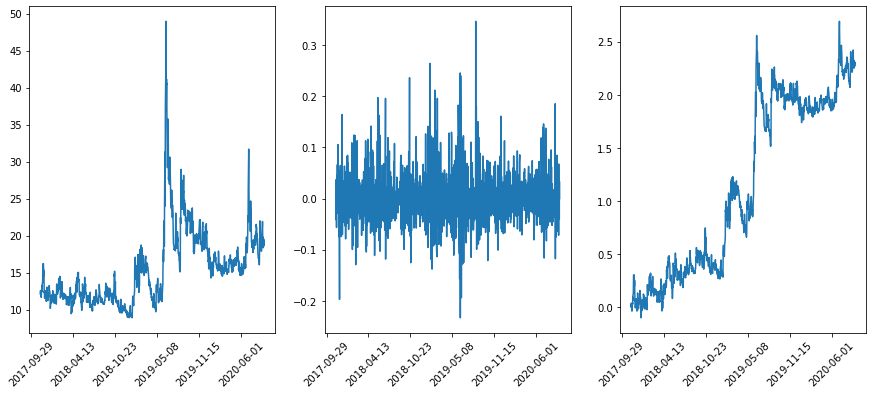

Unemployment UNRATE


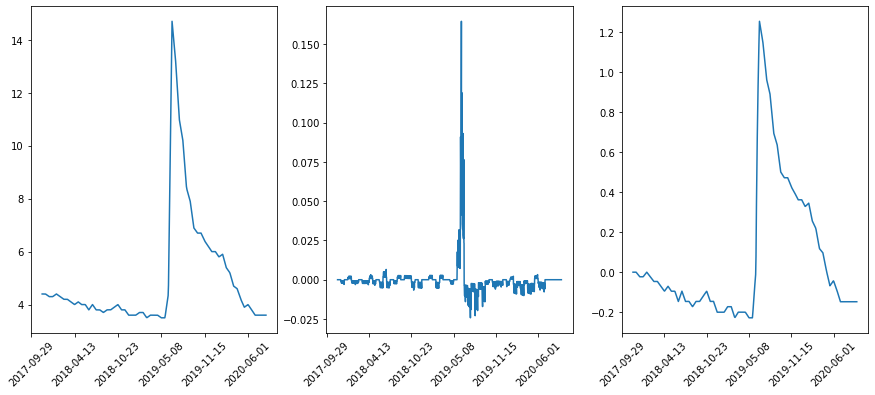

Market volatility VIXCLS


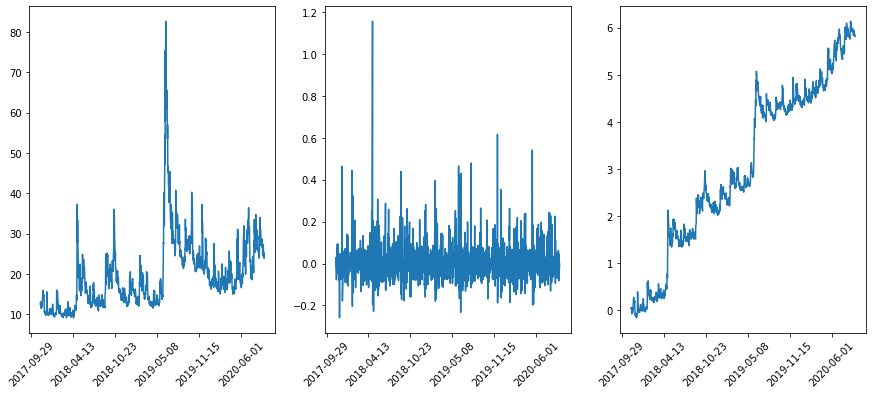

Commercial-Industrial Loans BUSLOANS


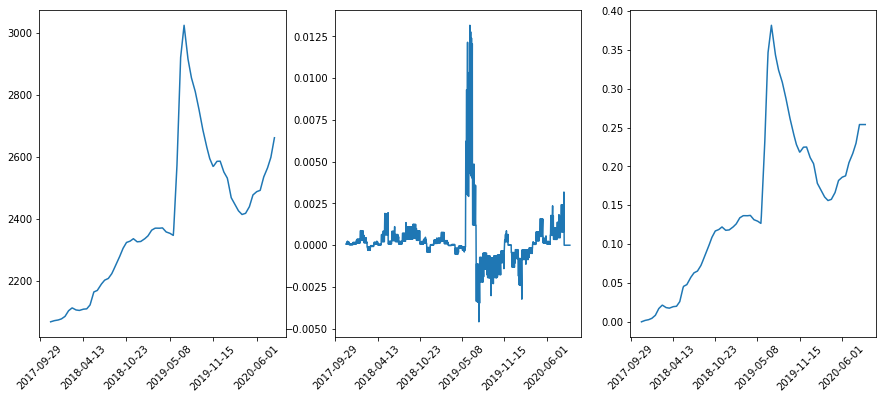

Average Weekly Hours AWHAETP


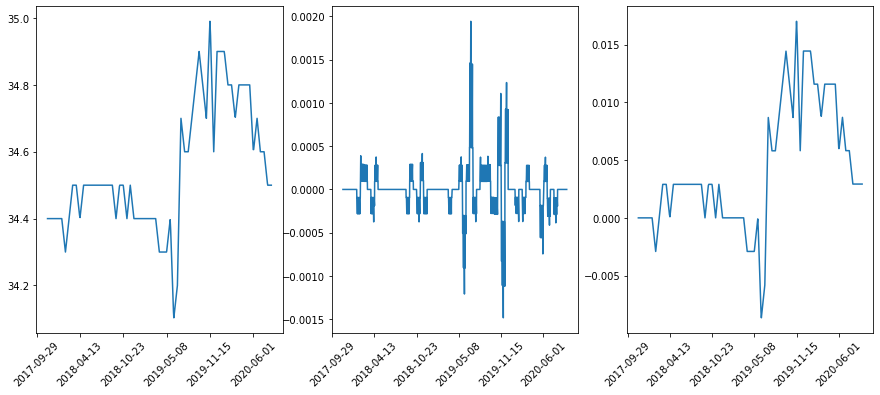

Credit to Income UMCSENT


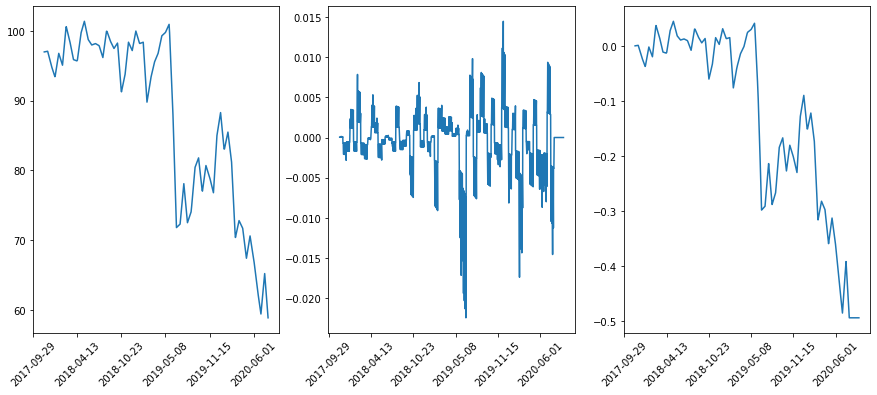

Consumer Confidence TDSP


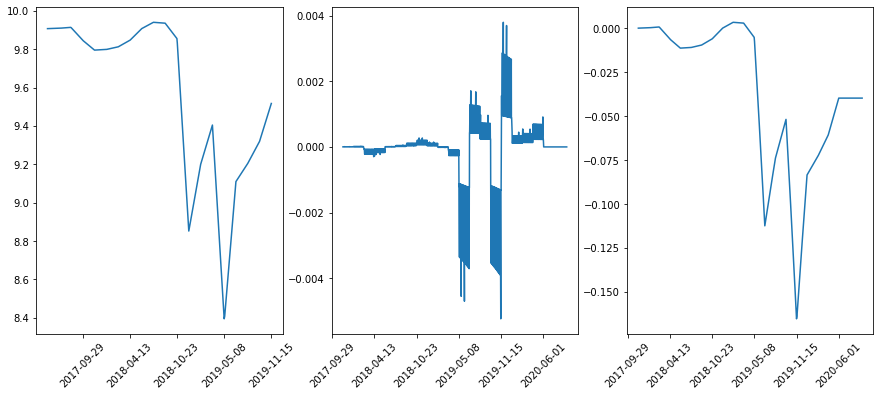

Oil Prices DCOILWTICO


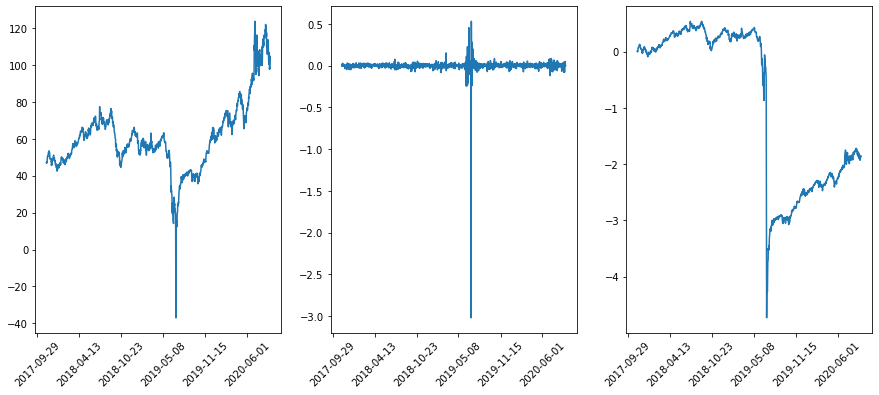

Inflation CPIAUCSL


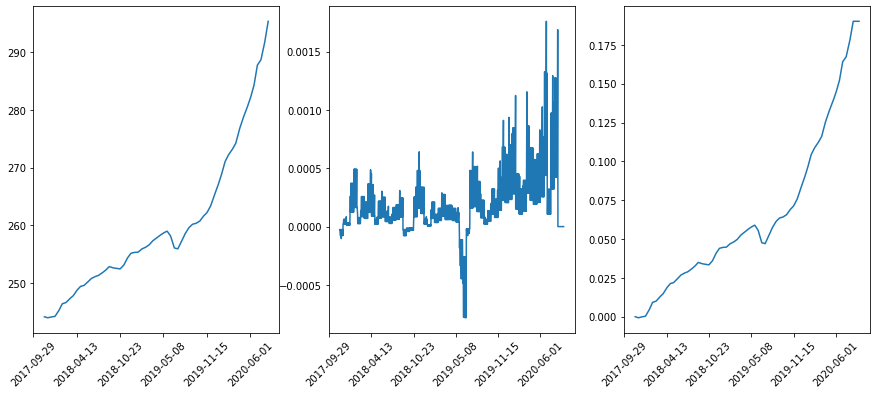

Housing Prices CSUSHPINSA


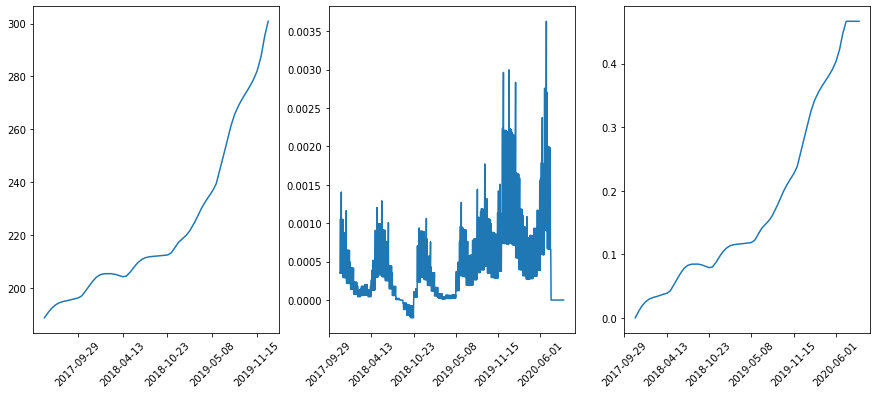

Interest Rates FEDFUNDS


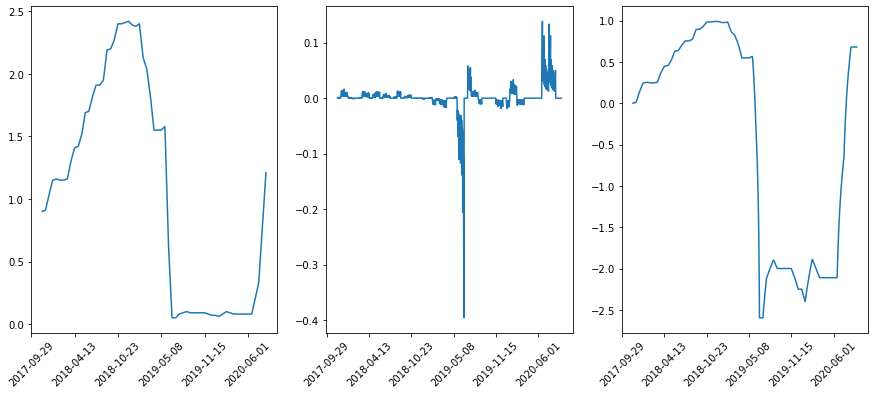

10 Year to 3 Month T10Y3M


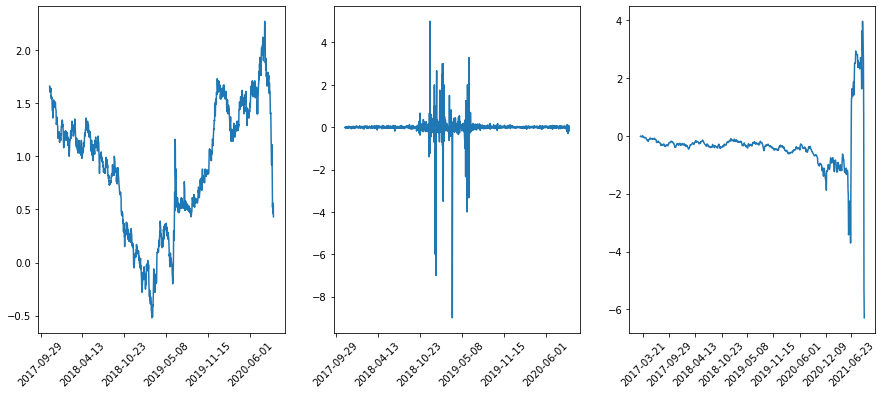

Recession Indicator USREC


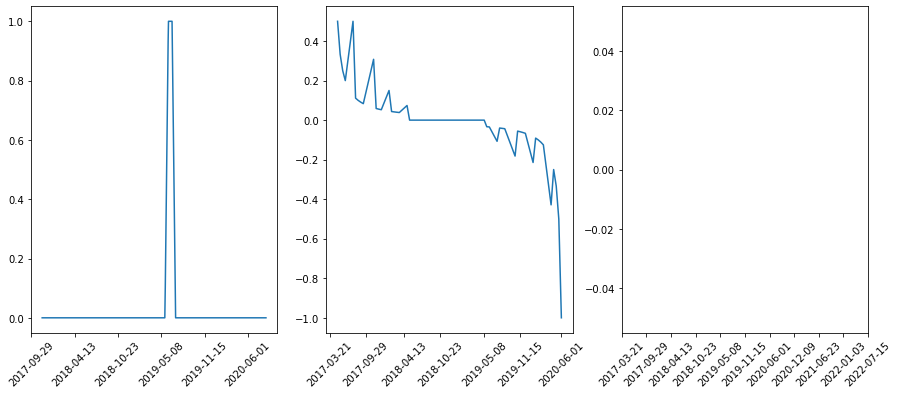

OECD Leading Indicator USALOLITONOSTSAM


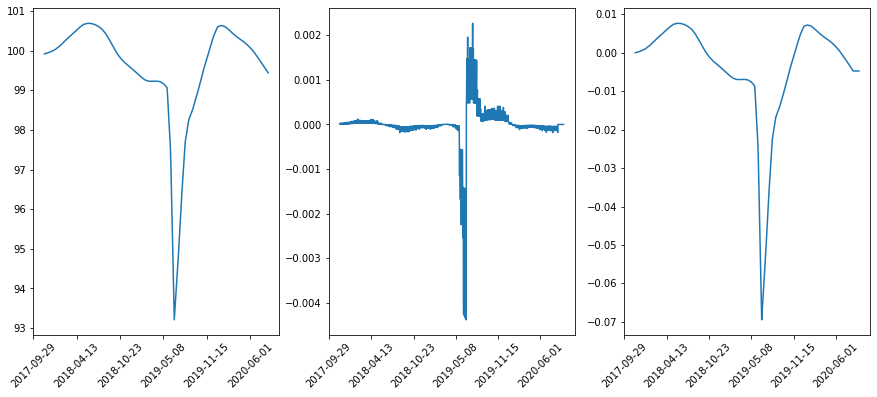

Coincident Index USPHCI


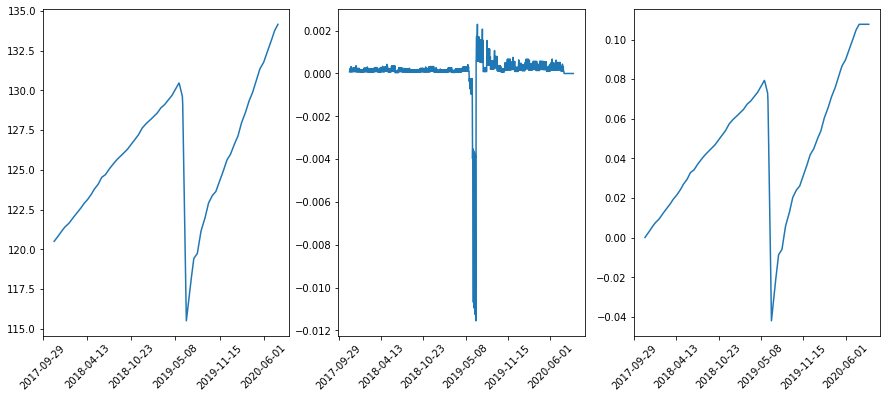

Index: Industrial Production INDPRO


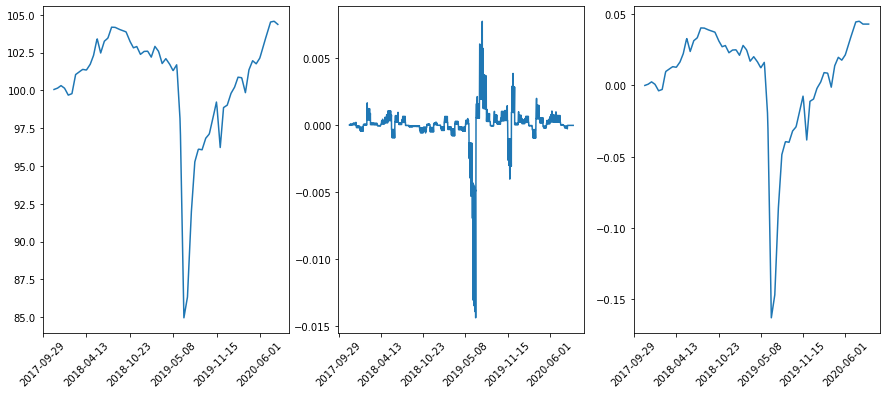

Mfr Orders Excl AC NEWORDER


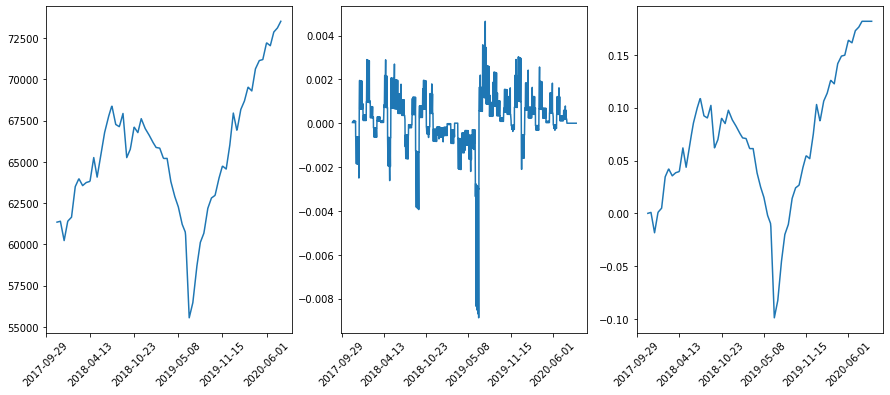

Personal Expenditures PCE


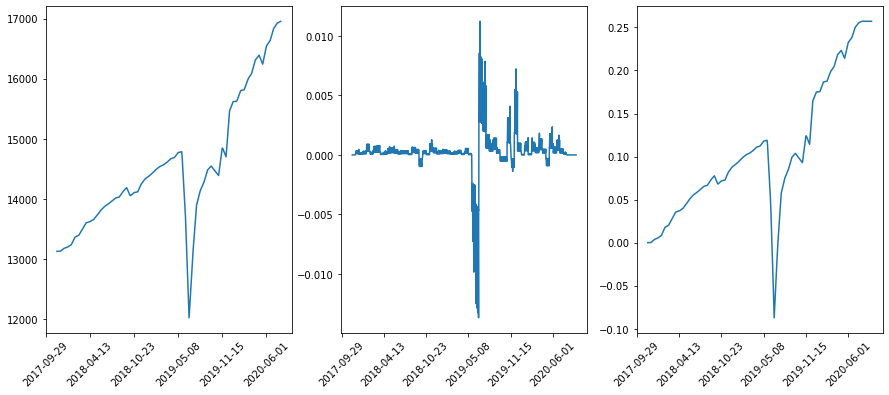

In [111]:
print('nominal,','pct_change,','pct_change().cumsum')
for pos in range(0,len(fred_names)):
    print(fred_friendly_names[pos],fred_names[pos])
    name = fred_names[pos]
    
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False,figsize=(15,6))
    ax1.plot(completed_fred_pvt_df[name])
    ax1.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
    ax2.plot(completed_fred_pvt_df[name].pct_change())
    ax2.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
    ax3.plot(completed_fred_pvt_df[name].pct_change().cumsum())
    ax3.set_xticklabels(np.array(completed_fred_pvt_df.index.map(lambda t: t.strftime('%Y-%m-%d')))[np.arange(0,len(completed_fred_pvt_df.index),int(len(completed_fred_pvt_df.index)/10))], rotation=45)
    plt.show()

In [112]:
#screener['vol_30d_2yr']

In [113]:
#pd.DataFrame(np.mean(np.exp(final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d')).summary_frame())[['mean','pi_lower']],axis=1)).iloc[0].values[0]
#[s,e_return,s_date,stop_loss_price,days_delta,discounted_return,qtr_return,test_score_mean,test_score_std,mean_revert_flag,p_metrics['pi_lower'].values[0],p_metrics['pi_upper'].values[0]]
#screener['Adj Close'].loc[decision_metrics_df.index]

In [114]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#tscv = expanding_window(initial =52*2, horizon = 13,period = 26)

#batchClearLimit = round(len(list__)/7)

print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")
"""*indexes['Symbol'].values,*sectors['Symbol'].values,"""
"""
widgets.Dropdown(
    #options=stocks_,
    #value=None,
    description='Choose Stock:',
    disabled=False,
)

#y_=widgets.Select(options=stocks_,disabled=False)
y_=widgets.Select(options=np.sort([*list_sector_n_indexes,*list_stocks]),value=None,disabled=False)

a=interact(plot_,symbol_=y_)
"""

adf < .05 or .01, mean reverting
Hurst
> .5 - The time series is mean reverting.
= .5 - The time series is a Geometric Brownian Motion.
< .5 - The time series is trending.


"\nwidgets.Dropdown(\n    #options=stocks_,\n    #value=None,\n    description='Choose Stock:',\n    disabled=False,\n)\n\n#y_=widgets.Select(options=stocks_,disabled=False)\ny_=widgets.Select(options=np.sort([*list_sector_n_indexes,*list_stocks]),value=None,disabled=False)\n\na=interact(plot_,symbol_=y_)\n"

In [115]:
def process_values(values):
    
    sector_list = []
    symbol_list = []
    for i in np.array(values):
        t= dict_sectors[i]
        sector_list.append(t)
        
        sublist = filtered_screener_sorted[filtered_screener_sorted['Sector Symbol']==t].index
        temp_df = filtered_screener_sorted.loc[sublist]
        #temp_df_ = temp_df['risk_trend_factor'].replace(['error','missing'], np.nan).dropna()
        
        #temp_df_filtered = temp_df_[temp_df_>0]
        
        flat_list = [item for item in temp_df.index]
        symbol_list.extend(flat_list)        
    
    button = widgets.Button(description="Process")
    output = widgets.Output()

    display(button, output)

    print("Symbols > 1 20td_tvf_vel")
    print(len(sector_list),sector_list)
    print(len(symbol_list),symbol_list)
    
    def on_button_clicked(b):
        with output:            
            plot_(symbol_list)

    button.on_click(on_button_clicked)    
    
y_=widgets.SelectMultiple(
    options=list(dict_sectors.keys()),
    description='Choose Sectors: ',
    disabled=False
)

a=interact(process_values,values=y_)

interactive(children=(SelectMultiple(description='Choose Sectors: ', options=('Basic Materials', 'Communicatio…

                        Sector
Healthcare                  17
Consumer Defensive          13
error                       12
Industrials                  7
Consumer Cyclical            5
Energy                       5
Financial Services           4
Technology                   3
Real Estate                  1
Communication Services       1


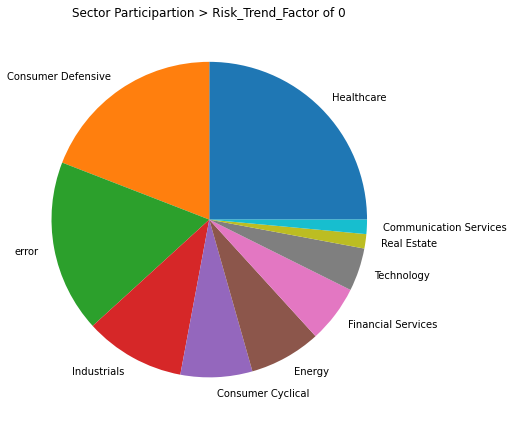

In [117]:
decision_metrics_df = pd.read_csv('..\\data\\processed\\'+end.strftime('%Y-%m-%d')+'_decision_metrics_df.csv')
decision_metrics_df.set_index(decision_metrics_df.iloc[:, 0],inplace=True)

counts_df = pd.DataFrame(decision_metrics_df['Sector'].value_counts())

print(counts_df)
fig, ax = plt.subplots()
ax.pie(counts_df['Sector'], labels=counts_df.index)
ax.set_title('Sector Participartion > Risk_Trend_Factor of 0')
plt.tight_layout()
plt.savefig('..\\reports\\figures\\'+end.strftime('%Y-%m-%d')+'_piechart-sectors.png', dpi=300, format='png', bbox_inches='tight')

In [118]:

prices_pvt_wk = pd.pivot_table(prices_df, values=['Adj Close'], index=prices_df.index,columns=['Symbol']).asfreq('d').interpolate().asfreq('W-'+nyse_dates.index[-1].strftime('%a'))
prices_pvt_wk.columns = prices_pvt_wk.columns.droplevel(0)


In [ ]:
from vevestaX import vevesta as v

try:
    V=v.Experiment()
    V.start()
    V.ds=decision_metrics_df
    V.fe=decision_metrics_df
    V.end()
    V.dump(techniqueUsed='fbprophet',filename='..\\reports\\'+end.strftime('%Y-%m-%d')+'_decision_metrics_df.xlsx',message="EDA-fbprophet-nested-CV",version=1)
    os.rename('EDA.pdf','..\\reports\\'+end.strftime('%Y-%m-%d')+'_decision_metrics_df.pdf')
    #os.remove('EDA.pdf')
except:
    pass

try:
    V=v.Experiment()
    V.start()
    V.ds=fred_pvt_sample
    V.fe=fred_pvt_sample
    V.end()
    V.dump(techniqueUsed='fred_data',filename='..\\reports\\'+end.strftime('%Y-%m-%d')+'_completed_fred_pvt.xlsx',message="EDA-fred",version=2)
    os.rename('EDA.pdf','..\\reports\\'+end.strftime('%Y-%m-%d')+'_completed_fred_pvt.pdf')
    
except:
    pass

try:
    V=v.Experiment()
    V.start()
    V.ds=prices_pvt_wk[filtered_screener_sorted.index]
    V.fe=prices_pvt_wk[filtered_screener_sorted.index]
    V.end()
    V.dump(techniqueUsed='price_data',filename='..\\reports\\'+end.strftime('%Y-%m-%d')+'_completed_prices_pvt_wk.xlsx',message="EDA-prices",version=3)
    os.rename('EDA.pdf','..\\reports\\'+end.strftime('%Y-%m-%d')+'_completed_prices_pvt_wk.pdf')
except:
    pass


In [121]:



c_df = prices_pvt_wk.corr()
c_df.sort_values(by='SPY',inplace=True,ascending=False,axis=1)
c_df.sort_values(by='SPY',inplace=True,ascending=False,axis=0)
c_df.to_csv('..\\reports\\'+end.strftime('%Y-%m-%d')+'_corr_5_yr_prices_pvt_wk.csv')

Inferred frequency is: W-THU
Model Number: 1 with model ARIMA in generation 0 of 4
Model Number: 2 with model ARIMA in generation 0 of 4
Model Number: 3 with model ARIMA in generation 0 of 4
Model Number: 4 with model AverageValueNaive in generation 0 of 4
Model Number: 5 with model AverageValueNaive in generation 0 of 4
Model Number: 6 with model AverageValueNaive in generation 0 of 4
Model Number: 7 with model DatepartRegression in generation 0 of 4
Model Number: 8 with model DatepartRegression in generation 0 of 4
Model Number: 9 with model DatepartRegression in generation 0 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 10 with model DatepartRegression in generation 0 of 4
Epoch 1/50
9/9 [==============================] - 10s 6ms/step - loss: 0.4027
Epoch 2/50
9/9 [==============================] - 0s 6ms/step - loss: 0.4023
Epoch 3/50
9/9 [==============================] - 0s 5ms/step - loss: 0.3991
Epoch 4/50
9/9 [==============================] - 0s 5ms/step - loss: 0.3996
Epoch 5/50
9/9 [==============================] - 0s 5ms/step - loss: 0.3973
Epoch 6/50
9/9 [==============================] - 0s 5ms/step - loss: 0.3995
Epoch 7/50
9/9 [==============================] - 0s 5ms/step - loss: 0.4020
Epoch 8/50
9/9 [==============================] - 0s 5ms/step - loss: 0.3997
Epoch 9/50
9/9 [==============================] - 0s 6ms/step - loss: 0.3994
Epoch 10/50
9/9 [==============================] - 0s 5ms/step - loss: 0.3983
Epoch 11/50
9/9 [==============================] - 0s 5ms/step - loss: 0.3979
Epoch 12/50
9/9 [==============================] - 0s 5ms/step - loss: 0.3974
Epoc

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 33 with model FBProphet in generation 0 of 4


00:51:22 - cmdstanpy - INFO - Chain [1] start processing
00:51:22 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 34 with model DatepartRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 34: DatepartRegression
Model Number: 35 with model SeasonalNaive in generation 0 of 4
Model Number: 36 with model DatepartRegression in generation 0 of 4
Model Number: 37 with model UnobservedComponents in generation 0 of 4
Model Number: 38 with model UnobservedComponents in generation 0 of 4
Model Number: 39 with model ETS in generation 0 of 4
Model Number: 40 with model VECM in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VECM') in model 40: VECM
Model Number: 41 with model ARDL in generation 0 of 4
Template Eval Error: ImportError("cannot import name 'ARDL' from 'statsmodels.tsa.api' (C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\statsmodels\\tsa\\api.py)") in model 41: ARDL
Model Number: 42 with model MultivariateMotif in generation 0 of 4
Model Number:

00:51:25 - cmdstanpy - INFO - Chain [1] start processing
00:51:26 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 49 with model SeasonalNaive in generation 0 of 4
Model Number: 50 with model DatepartRegression in generation 0 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 51 with model NVAR in generation 0 of 4
Model Number: 52 with model Theta in generation 0 of 4
Model Number: 53 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 53: ARCH
Model Number: 54 with model ETS in generation 0 of 4
Model Number: 55 with model FBProphet in generation 0 of 4


00:51:29 - cmdstanpy - INFO - Chain [1] start processing
00:51:29 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 56 with model ARIMA in generation 0 of 4
Model Number: 57 with model GLM in generation 0 of 4
Model Number: 58 with model UnobservedComponents in generation 0 of 4
Model Number: 59 with model Greykite in generation 0 of 4
Template Eval Error: ImportError('Package greykite is required') in model 59: Greykite
Model Number: 60 with model UnivariateMotif in generation 0 of 4
Model Number: 61 with model MultivariateMotif in generation 0 of 4
Model Number: 62 with model Theta in generation 0 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.19494640738911, tolerance: 0.0264
  model = cd_fast.enet_coordinate_descent(


Model Number: 63 with model ARDL in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 63: ARDL
Model Number: 64 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 64: ARCH
Model Number: 65 with model ConstantNaive in generation 0 of 4
Model Number: 66 with model LastValueNaive in generation 0 of 4
Model Number: 67 with model AverageValueNaive in generation 0 of 4
Model Number: 68 with model GLS in generation 0 of 4
Template Eval Error: Exception('Transformer PCA failed on fit') in model 68: GLS
Model Number: 69 with model SeasonalNaive in generation 0 of 4
Model Number: 70 with model VAR in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VAR') in model 70: VAR
Model Number: 71 with model VECM in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VECM') in model 71: VECM
Model Number: 72 with 

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 74 with model SectionalMotif in generation 0 of 4
Model Number: 75 with model NVAR in generation 0 of 4
Model Number: 76 with model ARDL in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 76: ARDL
Model Number: 77 with model DatepartRegression in generation 0 of 4
Model Number: 78 with model UnivariateMotif in generation 0 of 4
Model Number: 79 with model GLS in generation 0 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 80 with model SectionalMotif in generation 0 of 4
Template Eval Error: ValueError('Model SectionalMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 80: SectionalMotif
Model Number: 81 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 81: ARCH
Model Number: 82 with model DatepartRegression in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 82: DatepartRegression
Model Number: 83 with model Theta in generation 0 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 84 with model ARCH in generation 0 of 4
Template Eval Error: Exception('Transformer RobustScaler failed on fit') in model 84: ARCH
Model Number: 85 with model LastValueNaive in generation 0 of 4
Model Number: 86 with model GLM in generation 0 of 4
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 86: GLM
Model Number: 87 with model AverageValueNaive in generation 0 of 4
Model Number: 88 with model SectionalMotif in generation 0 of 4
Template Eval Error: ValueError('kth(=100) out of bounds (25)') in model 88: SectionalMotif
Model Number: 89 with model ARDL in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 89: ARDL
Model Number: 90 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 90: ARCH

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,



Model Number: 91 with model ARDL in generation 0 of 4
Template Eval Error: ImportError("cannot import name 'ARDL' from 'statsmodels.tsa.api' (C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\statsmodels\\tsa\\api.py)") in model 91: ARDL
Model Number: 92 with model ETS in generation 0 of 4
Model Number: 93 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 93: ARCH
Model Number: 94 with model ETS in generation 0 of 4
Model Number: 95 with model UnivariateMotif in generation 0 of 4
Model Number: 96 with model MultivariateMotif in generation 0 of 4
Model Number: 97 with model VAR in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VAR') in model 97: VAR
Model Number: 98 with model VAR in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VAR') in model 98: VAR
Model Number: 99 with model UnobservedComponents in generation 0 of 4
Mo

00:51:58 - cmdstanpy - INFO - Chain [1] start processing
00:51:58 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 116 with model GLS in generation 0 of 4
Model Number: 117 with model Greykite in generation 0 of 4
Template Eval Error: ImportError('Package greykite is required') in model 117: Greykite
Model Number: 118 with model AverageValueNaive in generation 0 of 4
Model Number: 119 with model VAR in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VAR') in model 119: VAR
Model Number: 120 with model ARIMA in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 120: ARIMA
Model Number: 121 with model GLM in generation 0 of 4
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 121: GLM
Model Number: 122 with model ETS in generation 0 of 4
Model Number: 123 with model ConstantNaive in generation 0 of 4
Model Number: 124 with model GLM in generation 0 of 4
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


Model Number: 137 with model LastValueNaive in generation 0 of 4
Model Number: 138 with model GLS in generation 0 of 4
Model Number: 139 with model ETS in generation 0 of 4
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on HSY with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 140 with model VECM in generation 0 of 4
Template Eval Error: ValueError('Only gave one variable to VECM') in model 140: VECM
Model Number: 141 with model ConstantNaive in generation 0 of 4
Model Number: 142 with model SectionalMotif in generation 0 of 4
Model Number: 143 with model SeasonalNaive in generation 0 of 4
Model Number: 144 with model NVAR in generation 0 of 4
Model Number: 145 with model ARCH in generation 0 of 4
Template Eval Error: ImportError('`arch` package must be installed from pip') in model 145: ARCH
Model Number: 146 with model VAR in generation 0 of 

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_regression.py:421: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Model Number: 162 with model ARDL in generation 0 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 162: ARDL
Model Number: 163 with model ConstantNaive in generation 0 of 4
New Generation: 1 of 4
Model Number: 164 with model LastValueNaive in generation 1 of 4
Model Number: 165 with model MultivariateMotif in generation 1 of 4
Template Eval Error: ValueError('Model MultivariateMotif returned NaN for one or more series. fail_on_forecast_nan=True') in model 165: MultivariateMotif
Model Number: 166 with model Theta in generation 1 of 4
Model Number: 167 with model ConstantNaive in generation 1 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Model Number: 168 with model GLM in generation 1 of 4
Model Number: 169 with model WindowRegression in generation 1 of 4
Epoch 1/50
3/3 [==============================] - 3s 228ms/step - loss: 0.5664 - val_loss: 0.4431
Epoch 2/50
3/3 [==============================] - 0s 39ms/step - loss: 0.5538 - val_loss: 0.4356
Epoch 3/50
3/3 [==============================] - 0s 39ms/step - loss: 0.5419 - val_loss: 0.4280
Epoch 4/50
3/3 [==============================] - 0s 39ms/step - loss: 0.5254 - val_loss: 0.4206
Epoch 5/50
3/3 [==============================] - 0s 37ms/step - loss: 0.5142 - val_loss: 0.4133
Epoch 6/50
3/3 [==============================] - 0s 35ms/step - loss: 0.4956 - val_loss: 0.4062
Epoch 7/50
3/3 [==============================] - 0s 35ms/step - loss: 0.4791 - val_loss: 0.3993
Epoch 8/50
3/3 [==============================] - 0s 34ms/step - loss: 0.4777 - val_loss: 0.3923
Epoch 9/50
3/3 [==============================] - 0s 35ms/step - loss: 0.4510 - val_loss: 0.3854
Epoch

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 183 with model WindowRegression in generation 1 of 4
Model Number: 184 with model ConstantNaive in generation 1 of 4
Model Number: 185 with model DatepartRegression in generation 1 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 186 with model UnobservedComponents in generation 1 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 186: UnobservedComponents
Model Number: 187 with model ETS in generation 1 of 4
Model Number: 188 with model ARIMA in generation 1 of 4
Model Number: 189 with model AverageValueNaive in generation 1 of 4
Model Number: 190 with model NVAR in generation 1 of 4
Model Number: 191 with model AverageValueNaive in generation 1 of 4
Model Number: 192 with model ARIMA in generation 1 of 4
Model Number: 193 with model AverageValueNaive in generation 1 of 4
Model Number: 194 with model SeasonalNaive in generation 1 of 4
Model Number: 195 with model Theta in generation 1 of 4
Model Number: 196 with model DatepartRegression in generation 1 of 4
Model Number: 197 with model AverageValueNaive in generation 1 of 4
Model Number: 198 with model SectionalMotif in generation 1 of 4
Model Number: 199 with model ETS in generation 1 of 4
Mo

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 204 with model ETS in generation 1 of 4
Model Number: 205 with model SectionalMotif in generation 1 of 4
Model Number: 206 with model FBProphet in generation 1 of 4


00:53:21 - cmdstanpy - INFO - Chain [1] start processing
00:53:21 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 207 with model ARIMA in generation 1 of 4
Model Number: 208 with model UnivariateMotif in generation 1 of 4
Model Number: 209 with model SectionalMotif in generation 1 of 4
Model Number: 210 with model SeasonalNaive in generation 1 of 4
Model Number: 211 with model Theta in generation 1 of 4
Model Number: 212 with model LastValueNaive in generation 1 of 4
Model Number: 213 with model SeasonalNaive in generation 1 of 4
Model Number: 214 with model UnobservedComponents in generation 1 of 4
Model Number: 215 with model MultivariateMotif in generation 1 of 4
Model Number: 216 with model ARIMA in generation 1 of 4
Model Number: 217 with model MultivariateMotif in generation 1 of 4
Model Number: 218 with model LastValueNaive in generation 1 of 4
Model Number: 219 with model WindowRegression in generation 1 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 219: WindowRegression
Model Number: 220 with model ARIMA in generation 

00:53:30 - cmdstanpy - INFO - Chain [1] start processing
00:53:30 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 227 with model FBProphet in generation 1 of 4


00:53:33 - cmdstanpy - INFO - Chain [1] start processing
00:53:34 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 228 with model LastValueNaive in generation 1 of 4
Model Number: 229 with model ETS in generation 1 of 4
Model Number: 230 with model UnobservedComponents in generation 1 of 4
Model Number: 231 with model ARIMA in generation 1 of 4
Model Number: 232 with model MultivariateMotif in generation 1 of 4
Model Number: 233 with model FBProphet in generation 1 of 4


00:53:47 - cmdstanpy - INFO - Chain [1] start processing
00:53:48 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 234 with model UnivariateMotif in generation 1 of 4
Model Number: 235 with model MultivariateMotif in generation 1 of 4
Model Number: 236 with model FBProphet in generation 1 of 4


00:53:51 - cmdstanpy - INFO - Chain [1] start processing
00:53:51 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 237 with model SeasonalNaive in generation 1 of 4
Model Number: 238 with model ETS in generation 1 of 4
Template Eval Error: ValueError('Model ETS returned NaN for one or more series. fail_on_forecast_nan=True') in model 238: ETS
Model Number: 239 with model ARIMA in generation 1 of 4
Model Number: 240 with model LastValueNaive in generation 1 of 4
Model Number: 241 with model ETS in generation 1 of 4
Model Number: 242 with model SectionalMotif in generation 1 of 4
Model Number: 243 with model MultivariateMotif in generation 1 of 4
Model Number: 244 with model ETS in generation 1 of 4
ETS failed on HSY with ValueError('could not broadcast input array from shape (264,) into shape (364,)')
Model Number: 245 with model SectionalMotif in generation 1 of 4
Model Number: 246 with model UnobservedComponents in generation 1 of 4
Model Number: 247 with model AverageValueNaive in generation 1 of 4
Model Number: 248 with model WindowRegression in generation 1 of 4
Template Eval Erro

00:54:36 - cmdstanpy - INFO - Chain [1] start processing
00:54:37 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 251 with model GLS in generation 1 of 4
Model Number: 252 with model ARIMA in generation 1 of 4
Model Number: 253 with model Theta in generation 1 of 4
Model Number: 254 with model LastValueNaive in generation 1 of 4
Model Number: 255 with model FBProphet in generation 1 of 4


00:54:45 - cmdstanpy - INFO - Chain [1] start processing
00:54:45 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 256 with model WindowRegression in generation 1 of 4
Model Number: 257 with model UnobservedComponents in generation 1 of 4
Model Number: 258 with model WindowRegression in generation 1 of 4
Model Number: 259 with model GLS in generation 1 of 4
Model Number: 260 with model ETS in generation 1 of 4
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on HSY with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 261 with model WindowRegression in generation 1 of 4
Model Number: 262 with model UnobservedComponents in generation 1 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 262: UnobservedComponents
Model Number: 263 with model AverageValueNaive in generation 1 of 4
Model Number: 264 with model LastValueNaive in generation 1 of 4
Model Number: 265 with model WindowRegression in genera

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22643.213368661436, tolerance: 29.981558637604817
  model = cd_fast.enet_coordinate_descent(


Model Number: 301 with model SeasonalNaive in generation 2 of 4
Model Number: 302 with model Theta in generation 2 of 4
Model Number: 303 with model LastValueNaive in generation 2 of 4
Model Number: 304 with model DatepartRegression in generation 2 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 305 with model WindowRegression in generation 2 of 4
Model Number: 306 with model ETS in generation 2 of 4
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on HSY with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 307 with model SeasonalNaive in generation 2 of 4
Model Number: 308 with model Theta in generation 2 of 4
Model Number: 309 with model DatepartRegression in generation 2 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 310 with model ETS in generation 2 of 4
Model Number: 311 with model SeasonalNaive in generation 2 of 4
Model Number: 312 with model UnobservedComponents in generation 2 of 4
Model Number: 313 with model DatepartRegression in generation 2 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 313: DatepartRegression
Model Number: 314 with model Theta in generation 2 of 4
Model Number: 315 with model SectionalMotif in generation 2 of 4
Model Number: 316 with model GLM in generation 2 of 4
Template Eval Error: TypeError("ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''") in model 316: GLM
Model Number: 317 with model MultivariateMotif in generation 2 of 4
Model Number: 318 with model LastValueNaive in generation 2 of 4
Model Number: 319 with model WindowRegression in generation 2 of 4
Model Number: 320 with model ARIMA i

00:55:27 - cmdstanpy - INFO - Chain [1] start processing
00:55:27 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 326 with model ARIMA in generation 2 of 4
Model Number: 327 with model GLM in generation 2 of 4
Model Number: 328 with model ETS in generation 2 of 4
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on HSY with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 329 with model UnobservedComponents in generation 2 of 4
Model Number: 330 with model MultivariateMotif in generation 2 of 4
Model Number: 331 with model LastValueNaive in generation 2 of 4
Model Number: 332 with model SeasonalNaive in generation 2 of 4
Model Number: 333 with model ARIMA in generation 2 of 4
Model Number: 334 with model SectionalMotif in generation 2 of 4
Model Number: 335 with model DatepartRegression in generation 2 of 4
Model Number: 336 with model AverageValueNaive in generation 2 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 337 with model UnobservedComponents in generation 2 of 4
Model Number: 338 with model ETS in generation 2 of 4
Model Number: 339 with model FBProphet in generation 2 of 4


00:55:32 - cmdstanpy - INFO - Chain [1] start processing
00:55:32 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 340 with model ConstantNaive in generation 2 of 4
Model Number: 341 with model ETS in generation 2 of 4
Model Number: 342 with model SectionalMotif in generation 2 of 4
Model Number: 343 with model FBProphet in generation 2 of 4


00:55:35 - cmdstanpy - INFO - Chain [1] start processing
00:55:35 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 344 with model AverageValueNaive in generation 2 of 4
Model Number: 345 with model AverageValueNaive in generation 2 of 4
Model Number: 346 with model NVAR in generation 2 of 4
Model Number: 347 with model NVAR in generation 2 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22176.517358143265, tolerance: 4.552933038159431
  model = cd_fast.enet_coordinate_descent(


Model Number: 348 with model SeasonalNaive in generation 2 of 4
Model Number: 349 with model LastValueNaive in generation 2 of 4
Model Number: 350 with model AverageValueNaive in generation 2 of 4
Model Number: 351 with model DatepartRegression in generation 2 of 4
Model Number: 352 with model ConstantNaive in generation 2 of 4
Model Number: 353 with model AverageValueNaive in generation 2 of 4
Model Number: 354 with model MultivariateMotif in generation 2 of 4
Model Number: 355 with model Theta in generation 2 of 4
Model Number: 356 with model FBProphet in generation 2 of 4


00:55:39 - cmdstanpy - INFO - Chain [1] start processing
00:55:39 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 357 with model ARIMA in generation 2 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 357: ARIMA
Model Number: 358 with model DatepartRegression in generation 2 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 359 with model FBProphet in generation 2 of 4


00:55:42 - cmdstanpy - INFO - Chain [1] start processing
00:55:42 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 360 with model UnivariateMotif in generation 2 of 4
Model Number: 361 with model SectionalMotif in generation 2 of 4
Model Number: 362 with model LastValueNaive in generation 2 of 4
Model Number: 363 with model ARIMA in generation 2 of 4
Model Number: 364 with model DatepartRegression in generation 2 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 365 with model AverageValueNaive in generation 2 of 4
Model Number: 366 with model FBProphet in generation 2 of 4


00:55:46 - cmdstanpy - INFO - Chain [1] start processing
00:55:46 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 367 with model SeasonalNaive in generation 2 of 4
Model Number: 368 with model ETS in generation 2 of 4
Model Number: 369 with model MultivariateMotif in generation 2 of 4
Model Number: 370 with model LastValueNaive in generation 2 of 4
Model Number: 371 with model ETS in generation 2 of 4
Model Number: 372 with model WindowRegression in generation 2 of 4
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Model Number: 373 with model WindowRegression in generation 2 of 4
Model Number: 374 with model ConstantNaive in generation 2 of 4
Model Number: 375 with model ARIMA in generation 2 of 4
Model Number: 376 with model NVAR in generation 2 of 4
Model Number: 377 with model UnobservedComponents in generation 2 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 377: UnobservedComponents
Model Number: 378 with model ConstantNaive in generation 2 of 4
Model Number: 379 with model DatepartRegression in generation 2 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.493189060094124, tolerance: 0.026399999999999996
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 380 with model LastValueNaive in generation 2 of 4
Model Number: 381 with model FBProphet in generation 2 of 4


00:55:51 - cmdstanpy - INFO - Chain [1] start processing
00:55:51 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 382 with model FBProphet in generation 2 of 4


00:55:54 - cmdstanpy - INFO - Chain [1] start processing
00:55:54 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 383 with model LastValueNaive in generation 2 of 4
New Generation: 3 of 4
Model Number: 384 with model AverageValueNaive in generation 3 of 4
Model Number: 385 with model UnobservedComponents in generation 3 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22176.517358143265, tolerance: 4.552933038159431
  model = cd_fast.enet_coordinate_descent(


Model Number: 386 with model WindowRegression in generation 3 of 4
Model Number: 387 with model ETS in generation 3 of 4
Model Number: 388 with model DatepartRegression in generation 3 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 389 with model AverageValueNaive in generation 3 of 4
Model Number: 390 with model UnivariateMotif in generation 3 of 4
Model Number: 391 with model GLS in generation 3 of 4
Model Number: 392 with model ETS in generation 3 of 4
Model Number: 393 with model GLS in generation 3 of 4
Model Number: 394 with model MultivariateMotif in generation 3 of 4
Model Number: 395 with model Theta in generation 3 of 4
Model Number: 396 with model FBProphet in generation 3 of 4


00:55:58 - cmdstanpy - INFO - Chain [1] start processing
00:55:58 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 397 with model NVAR in generation 3 of 4
Model Number: 398 with model AverageValueNaive in generation 3 of 4
Model Number: 399 with model AverageValueNaive in generation 3 of 4
Model Number: 400 with model Theta in generation 3 of 4
Model Number: 401 with model ARIMA in generation 3 of 4
Model Number: 402 with model LastValueNaive in generation 3 of 4
Model Number: 403 with model ETS in generation 3 of 4
Model Number: 404 with model DatepartRegression in generation 3 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 404: DatepartRegression
Model Number: 405 with model WindowRegression in generation 3 of 4
Model Number: 406 with model WindowRegression in generation 3 of 4
Model Number: 407 with model Theta in generation 3 of 4
Model Number: 408 with model FBProphet in generation 3 of 4


00:56:02 - cmdstanpy - INFO - Chain [1] start processing
00:56:02 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 409 with model LastValueNaive in generation 3 of 4
Model Number: 410 with model UnobservedComponents in generation 3 of 4
Model Number: 411 with model WindowRegression in generation 3 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26900.22246965392, tolerance: 5.5988684985944515
  model = cd_fast.enet_coordinate_descent(


Model Number: 412 with model WindowRegression in generation 3 of 4
Model Number: 413 with model WindowRegression in generation 3 of 4
Model Number: 414 with model LastValueNaive in generation 3 of 4
Model Number: 415 with model LastValueNaive in generation 3 of 4
Model Number: 416 with model AverageValueNaive in generation 3 of 4
Model Number: 417 with model MultivariateMotif in generation 3 of 4
Model Number: 418 with model LastValueNaive in generation 3 of 4
Model Number: 419 with model ARIMA in generation 3 of 4
Model Number: 420 with model ARIMA in generation 3 of 4
Model Number: 421 with model ARIMA in generation 3 of 4
Model Number: 422 with model LastValueNaive in generation 3 of 4
Model Number: 423 with model SeasonalNaive in generation 3 of 4
Model Number: 424 with model Theta in generation 3 of 4
Model Number: 425 with model SectionalMotif in generation 3 of 4
Model Number: 426 with model UnobservedComponents in generation 3 of 4
Template Eval Error: ValueError("regression_ty

00:56:13 - cmdstanpy - INFO - Chain [1] start processing
00:56:13 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 432 with model SectionalMotif in generation 3 of 4
Model Number: 433 with model ETS in generation 3 of 4
Model Number: 434 with model FBProphet in generation 3 of 4


00:56:16 - cmdstanpy - INFO - Chain [1] start processing
00:56:16 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 435 with model DatepartRegression in generation 3 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 436 with model WindowRegression in generation 3 of 4
Model Number: 437 with model GLS in generation 3 of 4
Model Number: 438 with model ETS in generation 3 of 4
ETS error ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
ETS failed on HSY with ValueError('endog must be strictly positive when usingmultiplicative trend or seasonal components.')
Model Number: 439 with model AverageValueNaive in generation 3 of 4
Model Number: 440 with model ARIMA in generation 3 of 4
Model Number: 441 with model ARIMA in generation 3 of 4
Model Number: 442 with model ConstantNaive in generation 3 of 4
Model Number: 443 with model UnivariateMotif in generation 3 of 4
Model Number: 444 with model MultivariateMotif in generation 3 of 4
Model Number: 445 with model ConstantNaive in generation 3 of 4
Model Number: 446 with model FBProphet in generation 3 of 4


00:56:31 - cmdstanpy - INFO - Chain [1] start processing
00:56:32 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 447 with model AverageValueNaive in generation 3 of 4
Model Number: 448 with model LastValueNaive in generation 3 of 4
Model Number: 449 with model ARIMA in generation 3 of 4
Model Number: 450 with model ARIMA in generation 3 of 4
Model Number: 451 with model SeasonalNaive in generation 3 of 4
Model Number: 452 with model UnobservedComponents in generation 3 of 4
Model Number: 453 with model UnobservedComponents in generation 3 of 4
Model Number: 454 with model AverageValueNaive in generation 3 of 4
Model Number: 455 with model AverageValueNaive in generation 3 of 4
Model Number: 456 with model FBProphet in generation 3 of 4


00:56:53 - cmdstanpy - INFO - Chain [1] start processing
00:56:53 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 457 with model UnobservedComponents in generation 3 of 4
Model Number: 458 with model LastValueNaive in generation 3 of 4
Model Number: 459 with model LastValueNaive in generation 3 of 4
Model Number: 460 with model ETS in generation 3 of 4
ETS error ValueError('Can only dampen the trend component')
ETS failed on HSY with ValueError('Can only dampen the trend component')
Model Number: 461 with model SectionalMotif in generation 3 of 4
Model Number: 462 with model ARIMA in generation 3 of 4
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 462: ARIMA
Model Number: 463 with model Theta in generation 3 of 4
Model Number: 464 with model SectionalMotif in generation 3 of 4
Model Number: 465 with model UnobservedComponents in generation 3 of 4
Model Number: 466 with model FBProphet in generation 3 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22643.213368661436, tolerance: 29.981558637604817
  model = cd_fast.enet_coordinate_descent(
00:56:56 - cmdstanpy - INFO - Chain [1] start processing
00:56:57 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 467 with model ETS in generation 3 of 4
Model Number: 468 with model DatepartRegression in generation 3 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 469 with model DatepartRegression in generation 3 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 470 with model WindowRegression in generation 3 of 4
Model Number: 471 with model SectionalMotif in generation 3 of 4
Model Number: 472 with model SeasonalNaive in generation 3 of 4
Model Number: 473 with model SeasonalNaive in generation 3 of 4
Model Number: 474 with model Theta in generation 3 of 4
Model Number: 475 with model WindowRegression in generation 3 of 4
Model Number: 476 with model FBProphet in generation 3 of 4


00:57:00 - cmdstanpy - INFO - Chain [1] start processing
00:57:00 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 477 with model UnivariateMotif in generation 3 of 4
Model Number: 478 with model ARIMA in generation 3 of 4
Model Number: 479 with model AverageValueNaive in generation 3 of 4
Model Number: 480 with model MultivariateMotif in generation 3 of 4
Template Eval Error: Exception('Transformer DifferencedTransformer failed on inverse') in model 480: MultivariateMotif
Model Number: 481 with model ConstantNaive in generation 3 of 4
Model Number: 482 with model DatepartRegression in generation 3 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19034.992321068035, tolerance: 4.557296454041894
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 483 with model WindowRegression in generation 3 of 4
Model Number: 484 with model ARIMA in generation 3 of 4
Model Number: 485 with model GLM in generation 3 of 4
Model Number: 486 with model Theta in generation 3 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\family.py:893: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)


Model Number: 487 with model AverageValueNaive in generation 3 of 4
Model Number: 488 with model SectionalMotif in generation 3 of 4
Model Number: 489 with model AverageValueNaive in generation 3 of 4
Model Number: 490 with model DatepartRegression in generation 3 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 300 out of 300 | elapsed:    0.0s finished


Model Number: 491 with model SeasonalNaive in generation 3 of 4
Model Number: 492 with model SeasonalNaive in generation 3 of 4
Model Number: 493 with model UnobservedComponents in generation 3 of 4
New Generation: 4 of 4
Model Number: 494 with model DatepartRegression in generation 4 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 495 with model Theta in generation 4 of 4
Model Number: 496 with model ARIMA in generation 4 of 4
Model Number: 497 with model UnivariateMotif in generation 4 of 4
Model Number: 498 with model SectionalMotif in generation 4 of 4
Model Number: 499 with model ARIMA in generation 4 of 4
Model Number: 500 with model AverageValueNaive in generation 4 of 4
Model Number: 501 with model UnobservedComponents in generation 4 of 4
Model Number: 502 with model AverageValueNaive in generation 4 of 4
Model Number: 503 with model FBProphet in generation 4 of 4


00:57:16 - cmdstanpy - INFO - Chain [1] start processing
00:57:16 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 504 with model LastValueNaive in generation 4 of 4
Model Number: 505 with model GLS in generation 4 of 4
Model Number: 506 with model LastValueNaive in generation 4 of 4
Model Number: 507 with model SectionalMotif in generation 4 of 4
Model Number: 508 with model WindowRegression in generation 4 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 508: WindowRegression
Model Number: 509 with model SeasonalNaive in generation 4 of 4
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 509: SeasonalNaive
Model Number: 510 with model WindowRegression in generation 4 of 4
Model Number: 511 with model ARIMA in generation 4 of 4
Model Number: 512 with model WindowRegression in generation 4 of 4
Model Number: 513 with model Theta in generation 4 of 4
Model Number: 514 with model NVAR in generation 4 of 4
Model Number: 515 with model ETS in generation 4 of 4
Model Number: 516 with model SectionalMotif in ge

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22643.213368661436, tolerance: 29.981558637604817
  model = cd_fast.enet_coordinate_descent(


Model Number: 519 with model DatepartRegression in generation 4 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 519: DatepartRegression
Model Number: 520 with model ARIMA in generation 4 of 4
Model Number: 521 with model WindowRegression in generation 4 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 521: WindowRegression
Model Number: 522 with model ARIMA in generation 4 of 4
Model Number: 523 with model ETS in generation 4 of 4
Model Number: 524 with model ARIMA in generation 4 of 4
Model Number: 525 with model UnobservedComponents in generation 4 of 4
Model Number: 526 with model AverageValueNaive in generation 4 of 4
Model Number: 527 with model WindowRegression in generation 4 of 4
Model Number: 528 with model UnivariateMotif in generation 4 of 4
Model Number: 529 with model ETS in generation 4 of 4
Model Number: 530 with model ARIMA in generation 4 of 4
Model Number: 531 

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.699276323622923, tolerance: 0.01205655581441605
  model = cd_fast.enet_coordinate_descent(


Model Number: 544 with model AverageValueNaive in generation 4 of 4
Model Number: 545 with model MultivariateMotif in generation 4 of 4
Model Number: 546 with model GLS in generation 4 of 4
Model Number: 547 with model Theta in generation 4 of 4
Model Number: 548 with model Theta in generation 4 of 4
Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'fake_date', 'transformations': {'0': 'cffilter', '1': 'IntermittentOccurrence', '2': 'Round', '3': 'ClipOutliers'}, 'transformation_params': {'0': {}, '1': {'center': 'mean'}, '2': {'decimals': 0, 'on_transform': False, 'on_inverse': True}, '3': {'method': 'clip', 'std_threshold': 2, 'fillna': None}}}. fail_on_forecast_nan=True") in model 548: Theta
Model Number: 549 with model GLM in generation 4 of 4
Model Number: 550 with model NVAR in generation 4 of 4
Model Number: 551 with model GLM in generation 4 of 4
Model Number: 552 with model LastValueNaive in generation 4 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:293: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 553 with model MultivariateMotif in generation 4 of 4
Model Number: 554 with model LastValueNaive in generation 4 of 4
Model Number: 555 with model DatepartRegression in generation 4 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 556 with model ETS in generation 4 of 4
Model Number: 557 with model ConstantNaive in generation 4 of 4
Model Number: 558 with model DatepartRegression in generation 4 of 4
Model Number: 559 with model ETS in generation 4 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model Number: 560 with model Theta in generation 4 of 4
Model Number: 561 with model ARIMA in generation 4 of 4
Model Number: 562 with model NVAR in generation 4 of 4
Model Number: 563 with model UnobservedComponents in generation 4 of 4
Model Number: 564 with model SeasonalNaive in generation 4 of 4
Model Number: 565 with model NVAR in generation 4 of 4
Model Number: 566 with model NVAR in generation 4 of 4
Template Eval Error: ValueError('Model NVAR returned NaN for one or more series. fail_on_forecast_nan=True') in model 566: NVAR
Model Number: 567 with model ETS in generation 4 of 4
Model Number: 568 with model SeasonalNaive in generation 4 of 4
Model Number: 569 with model GLM in generation 4 of 4
Template Eval Error: TypeError("ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''") in model 569: GLM
Model Number: 570 with model UnobservedComponents in generation 4 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22643.213368661436, tolerance: 29.981558637604817
  model = cd_fast.enet_coordinate_descent(


Model Number: 571 with model DatepartRegression in generation 4 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 571: DatepartRegression
Model Number: 572 with model AverageValueNaive in generation 4 of 4
Model Number: 573 with model WindowRegression in generation 4 of 4
Model Number: 574 with model SectionalMotif in generation 4 of 4
Model Number: 575 with model DatepartRegression in generation 4 of 4
Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 575: DatepartRegression
Model Number: 576 with model SectionalMotif in generation 4 of 4
Model Number: 577 with model GLS in generation 4 of 4
Model Number: 578 with model DatepartRegression in generation 4 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_regression.py:421: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:    1.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 1000 out of

Model Number: 579 with model DatepartRegression in generation 4 of 4


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


Model Number: 580 with model AverageValueNaive in generation 4 of 4
Model Number: 581 with model GLS in generation 4 of 4
Model Number: 582 with model SeasonalNaive in generation 4 of 4
Model Number: 583 with model UnobservedComponents in generation 4 of 4
Model Number: 584 with model LastValueNaive in generation 4 of 4
Model Number: 585 with model WindowRegression in generation 4 of 4
Model Number: 586 with model ConstantNaive in generation 4 of 4
Model Number: 587 with model FBProphet in generation 4 of 4


00:58:34 - cmdstanpy - INFO - Chain [1] start processing
00:58:34 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 588 with model FBProphet in generation 4 of 4


00:58:36 - cmdstanpy - INFO - Chain [1] start processing
00:58:36 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 589 with model WindowRegression in generation 4 of 4
Template Eval Error: ModuleNotFoundError("No module named 'lightgbm'") in model 589: WindowRegression
Model Number: 590 with model ConstantNaive in generation 4 of 4
Model Number: 591 with model LastValueNaive in generation 4 of 4
Model Number: 592 with model UnobservedComponents in generation 4 of 4


00:58:39 - cmdstanpy - INFO - Chain [1] start processing


Model Number: 593 with model FBProphet in generation 4 of 4


00:58:39 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 594 with model DatepartRegression in generation 4 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 594: DatepartRegression
Model Number: 595 with model WindowRegression in generation 4 of 4
Model Number: 596 with model NVAR in generation 4 of 4
Model Number: 597 with model AverageValueNaive in generation 4 of 4
Model Number: 598 with model Theta in generation 4 of 4
Model Number: 599 with model FBProphet in generation 4 of 4
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 599: FBProphet
Model Number: 600 with model FBProphet in generation 4 of 4


00:58:42 - cmdstanpy - INFO - Chain [1] start processing
00:58:42 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 601 with model ARIMA in generation 4 of 4
Model Number: 602 with model FBProphet in generation 4 of 4


00:58:45 - cmdstanpy - INFO - Chain [1] start processing
00:58:45 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 603 with model MultivariateMotif in generation 4 of 4


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.394730872068421, tolerance: 0.012039891078432749
  model = cd_fast.enet_coordinate_descent(


Validation Round: 1
Model Number: 1 of 90 with model ARIMA for Validation 1
📈 1 - ARIMA with avg smape 5.95: 
Model Number: 2 of 90 with model ARIMA for Validation 1
📈 2 - ARIMA with avg smape 5.86: 
Model Number: 3 of 90 with model ARIMA for Validation 1
3 - ARIMA with avg smape 5.86: 
Model Number: 4 of 90 with model ARIMA for Validation 1
4 - ARIMA with avg smape 5.86: 
Model Number: 5 of 90 with model ARIMA for Validation 1
5 - ARIMA with avg smape 6.18: 
Model Number: 6 of 90 with model ARIMA for Validation 1
📈 6 - ARIMA with avg smape 5.68: 
Model Number: 7 of 90 with model WindowRegression for Validation 1
7 - WindowRegression with avg smape 7.78: 
Model Number: 8 of 90 with model WindowRegression for Validation 1
8 - WindowRegression with avg smape 7.78: 
Model Number: 9 of 90 with model WindowRegression for Validation 1
9 - WindowRegression with avg smape 7.78: 
Model Number: 10 of 90 with model WindowRegression for Validation 1
10 - WindowRegression with avg smape 7.78: 
Mode

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


18 - DatepartRegression with avg smape 4.93: 
Model Number: 19 of 90 with model LastValueNaive for Validation 1
19 - LastValueNaive with avg smape 4.65: 
Model Number: 20 of 90 with model LastValueNaive for Validation 1
📈 20 - LastValueNaive with avg smape 4.58: 
Model Number: 21 of 90 with model SectionalMotif for Validation 1
📈 21 - SectionalMotif with avg smape 2.56: 
Model Number: 22 of 90 with model FBProphet for Validation 1


00:58:52 - cmdstanpy - INFO - Chain [1] start processing
00:58:52 - cmdstanpy - INFO - Chain [1] done processing


22 - FBProphet with avg smape 3.37: 
Model Number: 23 of 90 with model ETS for Validation 1
23 - ETS with avg smape 5.46: 
Model Number: 24 of 90 with model LastValueNaive for Validation 1
24 - LastValueNaive with avg smape 4.58: 
Model Number: 25 of 90 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:    1.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 1000 out of 1000 | elapsed:    0.1s finished


25 - DatepartRegression with avg smape 5.89: 
Model Number: 26 of 90 with model FBProphet for Validation 1


00:58:57 - cmdstanpy - INFO - Chain [1] start processing
00:58:57 - cmdstanpy - INFO - Chain [1] done processing


26 - FBProphet with avg smape 3.36: 
Model Number: 27 of 90 with model FBProphet for Validation 1


00:59:00 - cmdstanpy - INFO - Chain [1] start processing
00:59:00 - cmdstanpy - INFO - Chain [1] done processing


27 - FBProphet with avg smape 3.37: 
Model Number: 28 of 90 with model UnobservedComponents for Validation 1
28 - UnobservedComponents with avg smape 5.94: 
Model Number: 29 of 90 with model FBProphet for Validation 1


00:59:03 - cmdstanpy - INFO - Chain [1] start processing
00:59:03 - cmdstanpy - INFO - Chain [1] done processing


29 - FBProphet with avg smape 9.68: 
Model Number: 30 of 90 with model ETS for Validation 1
30 - ETS with avg smape 3.4: 
Model Number: 31 of 90 with model FBProphet for Validation 1


00:59:06 - cmdstanpy - INFO - Chain [1] start processing
00:59:06 - cmdstanpy - INFO - Chain [1] done processing


31 - FBProphet with avg smape 9.58: 
Model Number: 32 of 90 with model LastValueNaive for Validation 1
32 - LastValueNaive with avg smape 6.99: 
Model Number: 33 of 90 with model ETS for Validation 1
33 - ETS with avg smape 3.4: 
Model Number: 34 of 90 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


34 - DatepartRegression with avg smape 6.53: 
Model Number: 35 of 90 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


35 - DatepartRegression with avg smape 6.53: 
Model Number: 36 of 90 with model FBProphet for Validation 1


00:59:10 - cmdstanpy - INFO - Chain [1] start processing
00:59:10 - cmdstanpy - INFO - Chain [1] done processing


36 - FBProphet with avg smape 12.87: 
Model Number: 37 of 90 with model DatepartRegression for Validation 1


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


37 - DatepartRegression with avg smape 4.68: 
Model Number: 38 of 90 with model LastValueNaive for Validation 1
38 - LastValueNaive with avg smape 5.61: 
Model Number: 39 of 90 with model Theta for Validation 1
39 - Theta with avg smape 4.19: 
Model Number: 40 of 90 with model UnobservedComponents for Validation 1
40 - UnobservedComponents with avg smape 5.62: 
Model Number: 41 of 90 with model UnobservedComponents for Validation 1
41 - UnobservedComponents with avg smape 5.62: 
Model Number: 42 of 90 with model AverageValueNaive for Validation 1
42 - AverageValueNaive with avg smape 5.22: 
Model Number: 43 of 90 with model AverageValueNaive for Validation 1
43 - AverageValueNaive with avg smape 5.22: 
Model Number: 44 of 90 with model Theta for Validation 1
44 - Theta with avg smape 8.38: 
Model Number: 45 of 90 with model AverageValueNaive for Validation 1
45 - AverageValueNaive with avg smape 8.08: 
Model Number: 46 of 90 with model DatepartRegression for Validation 1


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16578.638469681617, tolerance: 3.6152111902427295
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


46 - DatepartRegression with avg smape 6.6: 
Model Number: 47 of 90 with model ETS for Validation 1
47 - ETS with avg smape 5.81: 
Model Number: 48 of 90 with model AverageValueNaive for Validation 1
48 - AverageValueNaive with avg smape 6.33: 
Model Number: 49 of 90 with model AverageValueNaive for Validation 1
49 - AverageValueNaive with avg smape 5.06: 
Model Number: 50 of 90 with model Theta for Validation 1
50 - Theta with avg smape 3.95: 
Model Number: 51 of 90 with model AverageValueNaive for Validation 1
51 - AverageValueNaive with avg smape 7.18: 
Model Number: 52 of 90 with model ETS for Validation 1
52 - ETS with avg smape 4.67: 
Model Number: 53 of 90 with model UnobservedComponents for Validation 1
53 - UnobservedComponents with avg smape 9.5: 
Model Number: 54 of 90 with model UnobservedComponents for Validation 1


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16610.933180742264, tolerance: 22.29016164274516
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16610.933180742264, tolerance: 22.29016164274516
  model = cd_fast.enet_coordinate_descent(


54 - UnobservedComponents with avg smape 9.73: 
Model Number: 55 of 90 with model UnobservedComponents for Validation 1
55 - UnobservedComponents with avg smape 4.57: 
Model Number: 56 of 90 with model GLS for Validation 1
56 - GLS with avg smape 4.85: 
Model Number: 57 of 90 with model SectionalMotif for Validation 1
57 - SectionalMotif with avg smape 3.41: 
Model Number: 58 of 90 with model ConstantNaive for Validation 1
58 - ConstantNaive with avg smape 4.65: 
Model Number: 59 of 90 with model SectionalMotif for Validation 1
59 - SectionalMotif with avg smape 4.33: 
Model Number: 60 of 90 with model SeasonalNaive for Validation 1
60 - SeasonalNaive with avg smape 10.95: 
Model Number: 61 of 90 with model MultivariateMotif for Validation 1
📈 61 - MultivariateMotif with avg smape 2.5: 
Model Number: 62 of 90 with model SeasonalNaive for Validation 1
62 - SeasonalNaive with avg smape 5.33: 
Model Number: 63 of 90 with model SeasonalNaive for Validation 1
63 - SeasonalNaive with avg sma

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in true_divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in true_divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in true_divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in true_divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarn

82 - ConstantNaive with avg smape 9.99: 
Model Number: 83 of 90 with model UnivariateMotif for Validation 1
83 - UnivariateMotif with avg smape 5.94: 
Model Number: 84 of 90 with model MultivariateMotif for Validation 1
84 - MultivariateMotif with avg smape 13.09: 
Model Number: 85 of 90 with model ConstantNaive for Validation 1
📈 85 - ConstantNaive with avg smape 1.89: 
Model Number: 86 of 90 with model MultivariateMotif for Validation 1
86 - MultivariateMotif with avg smape 10.85: 
Model Number: 87 of 90 with model NVAR for Validation 1
87 - NVAR with avg smape 13.22: 
Model Number: 88 of 90 with model UnivariateMotif for Validation 1
88 - UnivariateMotif with avg smape 8.81: 
Model Number: 89 of 90 with model UnivariateMotif for Validation 1
89 - UnivariateMotif with avg smape 13.71: 
Model Number: 90 of 90 with model NVAR for Validation 1
90 - NVAR with avg smape 7.35: 
Validation Round: 2
Model Number: 1 of 90 with model ARIMA for Validation 2
📈 1 - ARIMA with avg smape 3.61: 
Mod

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


📈 18 - DatepartRegression with avg smape 3.41: 
Model Number: 19 of 90 with model LastValueNaive for Validation 2
19 - LastValueNaive with avg smape 4.53: 
Model Number: 20 of 90 with model LastValueNaive for Validation 2
20 - LastValueNaive with avg smape 4.47: 
Model Number: 21 of 90 with model SectionalMotif for Validation 2
📈 21 - SectionalMotif with avg smape 2.56: 
Model Number: 22 of 90 with model FBProphet for Validation 2


00:59:22 - cmdstanpy - INFO - Chain [1] start processing
00:59:22 - cmdstanpy - INFO - Chain [1] done processing


📈 22 - FBProphet with avg smape 2.55: 
Model Number: 23 of 90 with model ETS for Validation 2
23 - ETS with avg smape 7.74: 
Model Number: 24 of 90 with model LastValueNaive for Validation 2
24 - LastValueNaive with avg smape 4.47: 
Model Number: 25 of 90 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:    1.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 1000 out of 1000 | elapsed:    0.1s finished


25 - DatepartRegression with avg smape 3.39: 
Model Number: 26 of 90 with model FBProphet for Validation 2


00:59:27 - cmdstanpy - INFO - Chain [1] start processing
00:59:27 - cmdstanpy - INFO - Chain [1] done processing


26 - FBProphet with avg smape 2.55: 
Model Number: 27 of 90 with model FBProphet for Validation 2


00:59:30 - cmdstanpy - INFO - Chain [1] start processing
00:59:30 - cmdstanpy - INFO - Chain [1] done processing


27 - FBProphet with avg smape 2.55: 
Model Number: 28 of 90 with model UnobservedComponents for Validation 2
28 - UnobservedComponents with avg smape 6.04: 
Model Number: 29 of 90 with model FBProphet for Validation 2


00:59:33 - cmdstanpy - INFO - Chain [1] start processing
00:59:33 - cmdstanpy - INFO - Chain [1] done processing


29 - FBProphet with avg smape 3.45: 
Model Number: 30 of 90 with model ETS for Validation 2
30 - ETS with avg smape 3.43: 
Model Number: 31 of 90 with model FBProphet for Validation 2


00:59:36 - cmdstanpy - INFO - Chain [1] start processing
00:59:36 - cmdstanpy - INFO - Chain [1] done processing


31 - FBProphet with avg smape 3.19: 
Model Number: 32 of 90 with model LastValueNaive for Validation 2
32 - LastValueNaive with avg smape 2.9: 
Model Number: 33 of 90 with model ETS for Validation 2
33 - ETS with avg smape 3.43: 
Model Number: 34 of 90 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


34 - DatepartRegression with avg smape 3.42: 
Model Number: 35 of 90 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


35 - DatepartRegression with avg smape 3.42: 
Model Number: 36 of 90 with model FBProphet for Validation 2


00:59:39 - cmdstanpy - INFO - Chain [1] start processing
00:59:39 - cmdstanpy - INFO - Chain [1] done processing


36 - FBProphet with avg smape 6.76: 
Model Number: 37 of 90 with model DatepartRegression for Validation 2


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


37 - DatepartRegression with avg smape 4.4: 
Model Number: 38 of 90 with model LastValueNaive for Validation 2
38 - LastValueNaive with avg smape 6.41: 
Model Number: 39 of 90 with model Theta for Validation 2
39 - Theta with avg smape 3.17: 
Model Number: 40 of 90 with model UnobservedComponents for Validation 2
40 - UnobservedComponents with avg smape 6.71: 
Model Number: 41 of 90 with model UnobservedComponents for Validation 2
41 - UnobservedComponents with avg smape 6.71: 
Model Number: 42 of 90 with model AverageValueNaive for Validation 2
42 - AverageValueNaive with avg smape 3.51: 
Model Number: 43 of 90 with model AverageValueNaive for Validation 2
43 - AverageValueNaive with avg smape 3.51: 
Model Number: 44 of 90 with model Theta for Validation 2
44 - Theta with avg smape 8.62: 
Model Number: 45 of 90 with model AverageValueNaive for Validation 2
45 - AverageValueNaive with avg smape 3.36: 
Model Number: 46 of 90 with model DatepartRegression for Validation 2


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15778.698636961695, tolerance: 3.3753933774746767
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.0s


46 - DatepartRegression with avg smape 3.42: 
Model Number: 47 of 90 with model ETS for Validation 2


[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.0s finished


47 - ETS with avg smape 6.63: 
Model Number: 48 of 90 with model AverageValueNaive for Validation 2
48 - AverageValueNaive with avg smape 5.85: 
Model Number: 49 of 90 with model AverageValueNaive for Validation 2
49 - AverageValueNaive with avg smape 3.6: 
Model Number: 50 of 90 with model Theta for Validation 2
50 - Theta with avg smape 2.97: 
Model Number: 51 of 90 with model AverageValueNaive for Validation 2
51 - AverageValueNaive with avg smape 7.07: 
Model Number: 52 of 90 with model ETS for Validation 2
52 - ETS with avg smape 4.34: 
Model Number: 53 of 90 with model UnobservedComponents for Validation 2
53 - UnobservedComponents with avg smape 5.37: 


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16414.12838012013, tolerance: 17.94317914167763
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16414.12838012013, tolerance: 17.94317914167763
  model = cd_fast.enet_coordinate_descent(


Model Number: 54 of 90 with model UnobservedComponents for Validation 2
54 - UnobservedComponents with avg smape 4.52: 
Model Number: 55 of 90 with model UnobservedComponents for Validation 2
55 - UnobservedComponents with avg smape 3.94: 
Model Number: 56 of 90 with model GLS for Validation 2
56 - GLS with avg smape 2.94: 
Model Number: 57 of 90 with model SectionalMotif for Validation 2
57 - SectionalMotif with avg smape 2.62: 
Model Number: 58 of 90 with model ConstantNaive for Validation 2
58 - ConstantNaive with avg smape 2.85: 
Model Number: 59 of 90 with model SectionalMotif for Validation 2
59 - SectionalMotif with avg smape 9.37: 
Model Number: 60 of 90 with model SeasonalNaive for Validation 2
60 - SeasonalNaive with avg smape 4.94: 
Model Number: 61 of 90 with model MultivariateMotif for Validation 2
📈 61 - MultivariateMotif with avg smape 1.89: 
Model Number: 62 of 90 with model SeasonalNaive for Validation 2
62 - SeasonalNaive with avg smape 6.11: 
Model Number: 63 of 90 w

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in true_divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in true_divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarning: invalid value encountered in true_divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\autots\tools\probabilistic.py:68: RuntimeWarning: divide by zero encountered in true_divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\autots\tools\probabilistic.py:67: RuntimeWarn

82 - ConstantNaive with avg smape 5.11: 
Model Number: 83 of 90 with model UnivariateMotif for Validation 2
83 - UnivariateMotif with avg smape 23.41: 
Model Number: 84 of 90 with model MultivariateMotif for Validation 2
84 - MultivariateMotif with avg smape 5.95: 
Model Number: 85 of 90 with model ConstantNaive for Validation 2
85 - ConstantNaive with avg smape 2.06: 
Model Number: 86 of 90 with model MultivariateMotif for Validation 2
86 - MultivariateMotif with avg smape 5.35: 
Model Number: 87 of 90 with model NVAR for Validation 2
87 - NVAR with avg smape 7.71: 
Model Number: 88 of 90 with model UnivariateMotif for Validation 2
88 - UnivariateMotif with avg smape 3.58: 
Model Number: 89 of 90 with model UnivariateMotif for Validation 2
89 - UnivariateMotif with avg smape 4.19: 
Model Number: 90 of 90 with model NVAR for Validation 2
90 - NVAR with avg smape 6.25: 
Initiated AutoTS object with best model: 
SectionalMotif
{'fillna': 'rolling_mean_24', 'transformations': {'0': 'ClipO

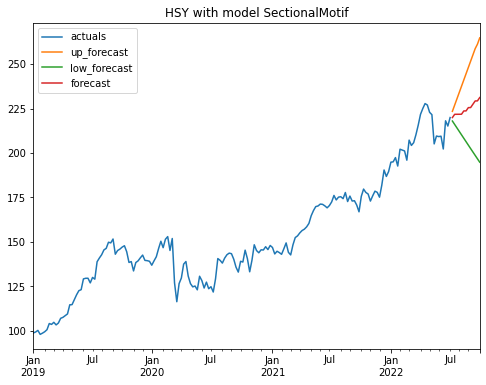

In [135]:
from autots import AutoTS, load_daily

# sample datasets can be used in either of the long or wide import shapes
long = False
#df = load_daily(long=long)
df = prices_pvt_wk['HSY']

model = AutoTS(
    forecast_length=13,
    frequency='infer',
    prediction_interval=0.9,
    ensemble=False,
    model_list="fast_parallel",  # "superfast", "default", "fast_parallel"
    transformer_list="fast",  # "superfast",
    drop_most_recent=1,
    max_generations=4,
    num_validations=2,
    validation_method="backwards"
)
model = model.fit(
    df,
    date_col='datetime' if long else None,
    value_col='value' if long else None,
    id_col='series_id' if long else None,
)

prediction = model.predict()
# plot a sample
prediction.plot(model.df_wide_numeric,
                series=model.df_wide_numeric.columns[0],
                start_date="2019-01-01")
# Print the details of the best model
print(model)

# point forecasts dataframe
forecasts_df = prediction.forecast
# upper and lower forecasts
forecasts_up, forecasts_low = prediction.upper_forecast, prediction.lower_forecast

# accuracy of all tried model results
model_results = model.results()
# and aggregated from cross validation
validation_results = model.results("validation")

2017-03-23    216.571640
2017-03-30    218.663086
2017-04-06    217.876480
2017-04-13    215.165070
2017-04-20    217.783951
                 ...    
2022-06-16    366.649994
2022-06-23    378.059998
2022-06-30    377.250000
2022-07-07    388.989990
2022-07-14    377.910004
Freq: W-THU, Name: SPY, Length: 278, dtype: float64